# Experiments with the latent IHDP data
This notebook contains the experiments and plots for the latent IHDP data set. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CEVAE import *
from cevaetools import *
%load_ext autoreload
%autoreload 2

# Loading the IHDP data

In [2]:
#Check what are the variable distributions like
ihdp_train = np.load("data/IHDP/ihdp_npci_1-1000.train.npz")
for var in ihdp_train['x'][:,:,0].T:
    uniques = np.unique(var)
    if len(uniques) > 4:
        print("Num of unique vals: ", len(uniques))
    else:
        print("Unique vals: ",uniques)

Num of unique vals:  205
Num of unique vals:  43
Num of unique vals:  14
Unique vals:  [-0.87960599  0.16170253  1.20301104  2.24431956]
Num of unique vals:  85
Num of unique vals:  30
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [1. 2.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]


In [3]:
#Preprocessing so that the fourth variable in the data set is transformed to categorical
import copy
def transform_x_data(x_data):
    new_x_data = copy.deepcopy(x_data)
    #Transform the 4th variable into a categorical variable
    vals_4th_var = np.unique(x_data[:,3,:])
    val_to_idx = dict(zip(vals_4th_var, range(len(vals_4th_var))))
    vfunc = np.vectorize(lambda x: val_to_idx[x])
    new_x_data[:,3,:] = vfunc(new_x_data[:,3,:])
    
    #Transform 14th variable to regular {0,1} representation
    new_x_data[:,13,:] = new_x_data[:,13,:]-1
    
    return new_x_data
    
ihdp_x_train = transform_x_data(ihdp_train['x'])

# Train the data generator

In [ ]:
# NOTE: This cell is not necessary to run, a pretrained model is provided
from datagenVAE import GenericDataset, train_datagenerator, savemodel, loadmodel, trainZtoTmodel, dataGeneratorVAE, FullyConnected
dataset = GenericDataset(ihdp_x_train[:,:,0])
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)
device='cpu'
plot_curves=False
print_logs=True
num_epochs=400
lr_start=0.02
lr_end=0.001
x_dim=ihdp_x_train.shape[1]
z_dim=10
x_mode=[0]*3+[4]+[0]*2+[2]*(x_dim-6)
#Remove the following comments to run
#proxymodel, losses = train_datagenerator(device, plot_curves, print_logs,
#              dataloader, num_epochs, lr_start, lr_end, x_dim, z_dim,
#              p_x_z_nn_layers=3, p_x_z_nn_width=30,
#              q_z_nn_layers=3, q_z_nn_width=30, x_mode=x_mode)
#savemodel(proxymodel, "proxygenerator")

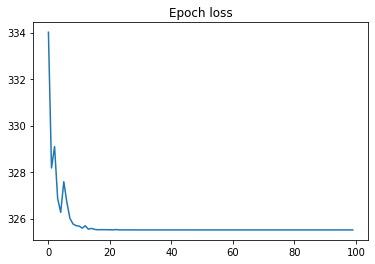

In [5]:
# NOTE: also not necessary to run, remove comments to do so
#model_zt = trainZtoTmodel(device, ihdp_x_train[:,4,0][:,None], ihdp_train['t'][:,1][:,None], lr_start=0.05, lr_end=0.01, num_epochs=100,layers=3, width=10)
#savemodel(model_zt, "ztotgenerator5")

# Load the data generator

In [9]:
from datagenVAE import GenericDataset, train_datagenerator, savemodel, loadmodel, trainZtoTmodel, dataGeneratorVAE, FullyConnected
x_dim=ihdp_x_train.shape[1]
z_dim=10
device='cpu'
x_mode=[0]*3+[4]+[0]*2+[2]*(x_dim-6)
proxymodel = loadmodel(name="proxygenerator", modeltype=dataGeneratorVAE, args=[x_dim, z_dim, device, 3, 30, 3, 30, x_mode])
model_zt = loadmodel("ztotgenerator", modeltype=FullyConnected, args=[[1]+[10]*3+[1]])

# Run loss scaling tests

### Generate data

In [20]:
# Generate data sets
from datagenVAE import generatedata
main_folder = "ihdpdataz5"
sub_folder = "ATE1samplesize20000times10"
ATE = 1
zvar_index = 5
dataparameters = [20000, proxymodel, model_zt, ATE, zvar_index]
generate_df = generatedata
param_times=30

In [301]:
dfs, datasets = create_dfs_datasets(generate_df, [dataparameters], param_times=10, repeat=True, 
                    main_folder=main_folder, sub_folder=sub_folder, labels=["df20000"])

In [21]:
dfs, datasets = load_dfs(main_folder, sub_folder, param_times)

### Run model

In [16]:
BATCH_SIZE = 200
track_function = lambda model: estimate_model_py_dot(model, 200000)
true_value = [0,1]
device = 'cpu'

num_epochs=200
lr_start=0.001
lr_end=0.00001
z_dim=10
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=30
q_z_nn_layers=3
q_z_nn_width=30
t_mode=2
y_mode=0
x_mode=np.delete(np.array([0]*3+[4]+[0]*2+[2]*(ihdp_x_train.shape[1]-6)),zvar_index)
x_dim = len(x_mode)
ty_separate_enc=True
z_mode=0
x_loss_scaling=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
common_stds=False

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]

sub_folder_model = "ATE1zdim10samplesize20000modelsscalings"
labels = x_loss_scaling
data_labels = ["df20000"]*10

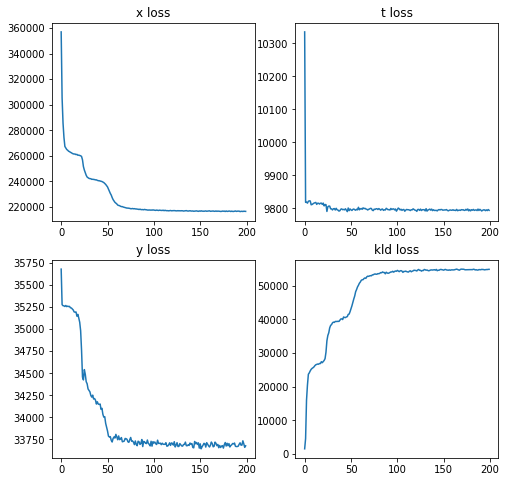

Total loss in the end:  314746.9338378906
Estimated causal effect: [0.02260617 0.87659937] true value: [0, 0.5]


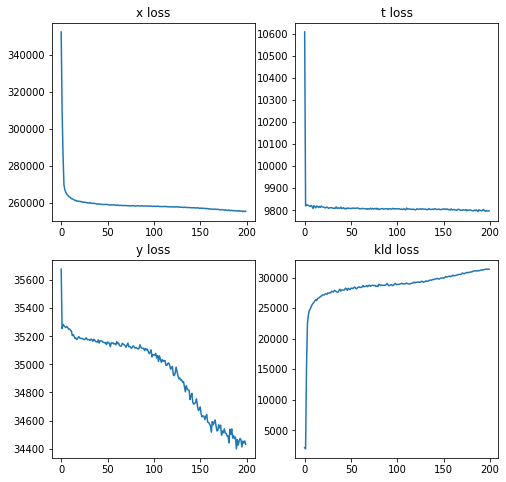

Total loss in the end:  330933.98046875
Estimated causal effect: [0.01930467 0.85727513] true value: [0, 0.5]


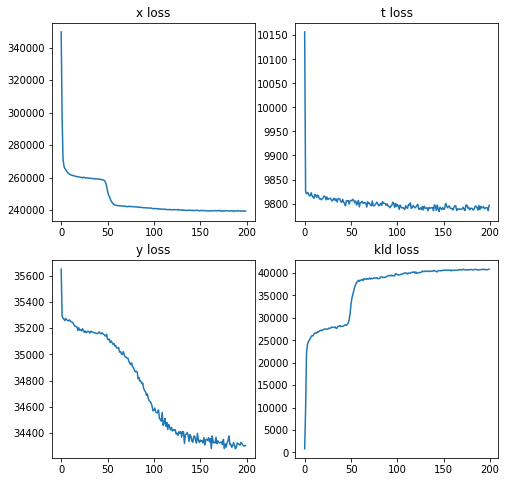

Total loss in the end:  324303.86865234375
Estimated causal effect: [0.02101415 0.86339062] true value: [0, 0.5]


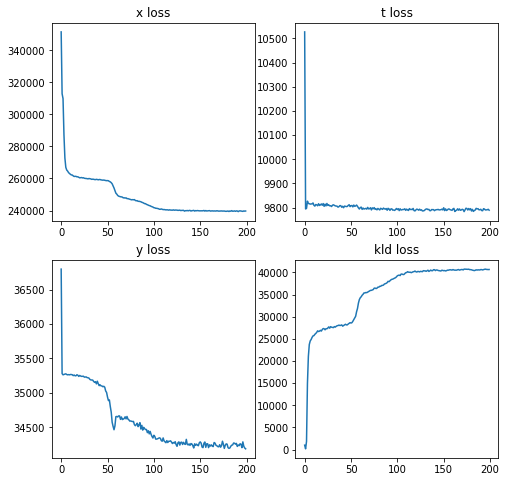

Total loss in the end:  324345.8215332031
Estimated causal effect: [0.02011406 0.86560065] true value: [0, 0.5]


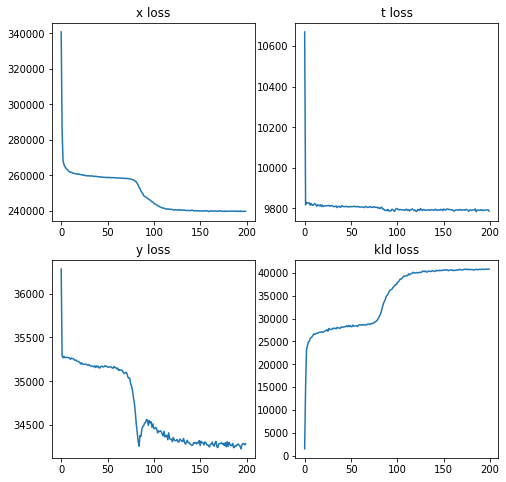

Total loss in the end:  324458.1022949219
Estimated causal effect: [0.0180126  0.86921144] true value: [0, 0.5]


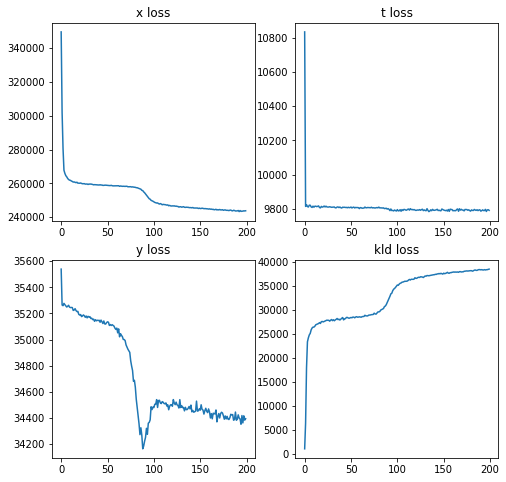

Total loss in the end:  326436.9172363281
Estimated causal effect: [0.02226563 0.8673597 ] true value: [0, 0.5]


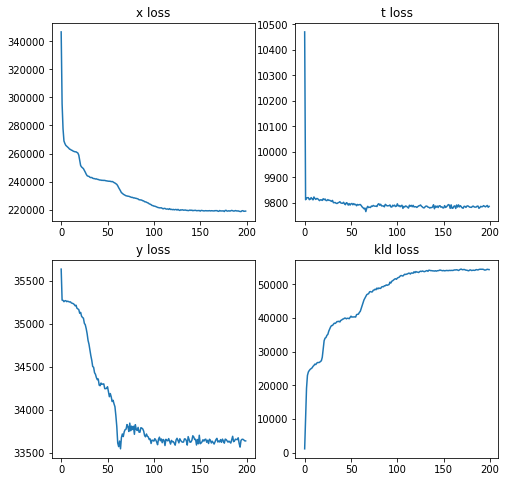

Total loss in the end:  316811.388671875
Estimated causal effect: [0.01080986 0.88066196] true value: [0, 0.5]


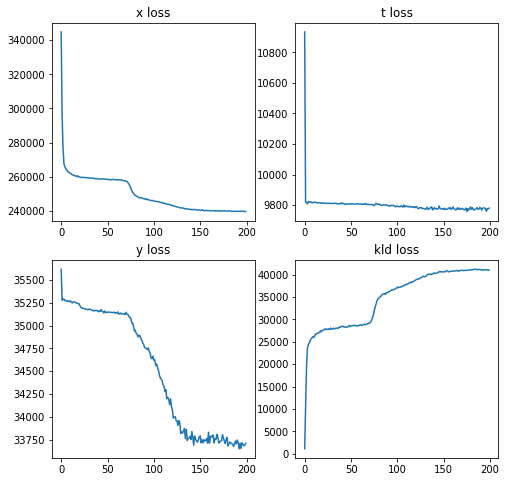

Total loss in the end:  324144.0520019531
Estimated causal effect: [0.02496145 0.83748525] true value: [0, 0.5]


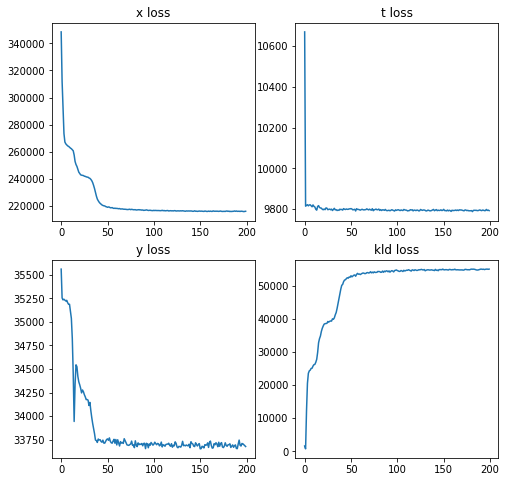

Total loss in the end:  314779.7087402344
Estimated causal effect: [0.02482001 0.87833506] true value: [0, 0.5]


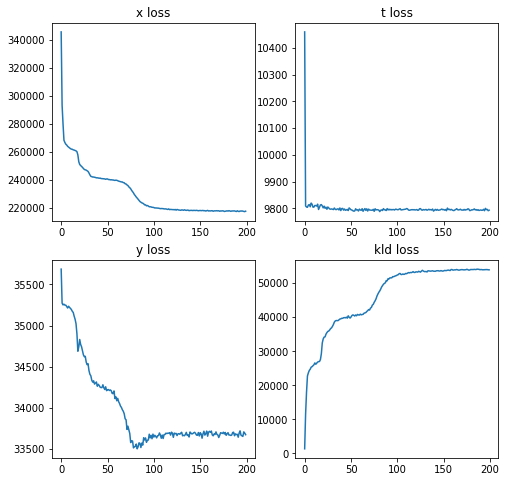

Total loss in the end:  314976.6325683594
Estimated causal effect: [0.0171083  0.87176639] true value: [0, 0.5]


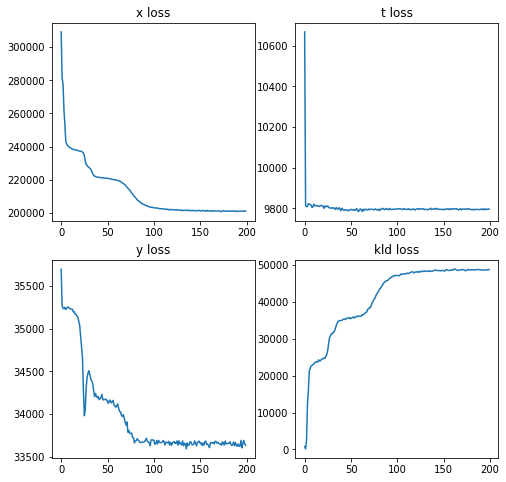

Total loss in the end:  293333.78515625
Estimated causal effect: [0.01761833 0.86789626] true value: [0, 0.5]


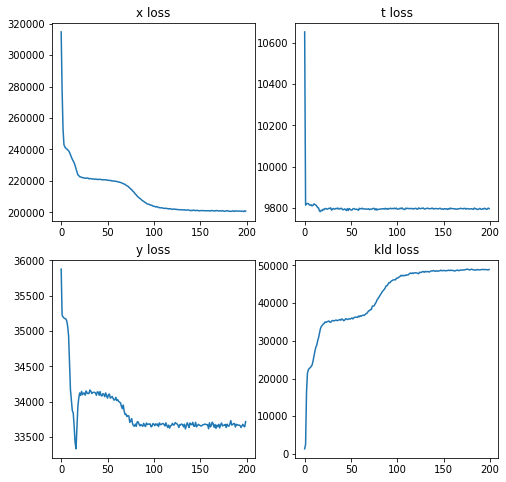

Total loss in the end:  293144.30224609375
Estimated causal effect: [0.02247415 0.87415111] true value: [0, 0.5]


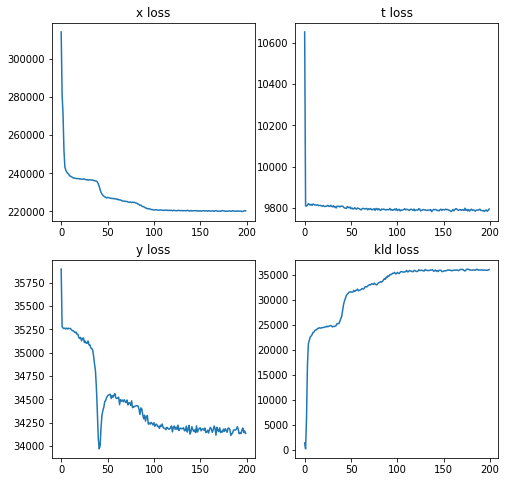

Total loss in the end:  300181.2067871094
Estimated causal effect: [0.01824459 0.87019509] true value: [0, 0.5]


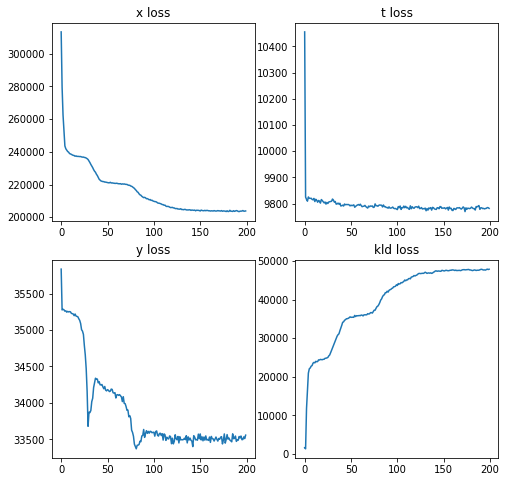

Total loss in the end:  295028.6584472656
Estimated causal effect: [0.00893165 0.88288391] true value: [0, 0.5]


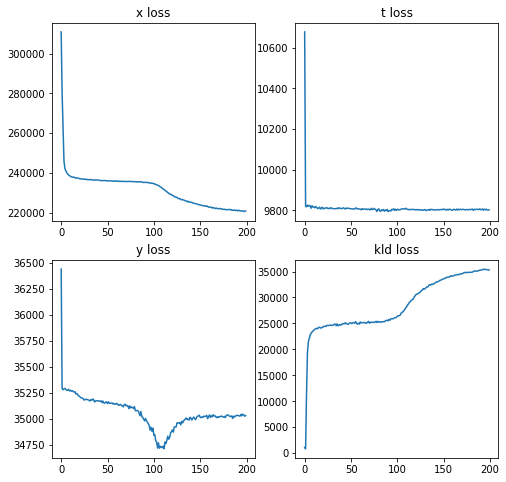

Total loss in the end:  301020.4694824219
Estimated causal effect: [0.02473559 0.84158921] true value: [0, 0.5]


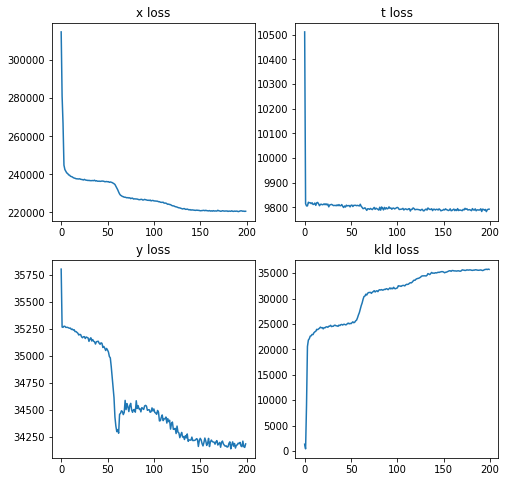

Total loss in the end:  300326.7272949219
Estimated causal effect: [0.01832798 0.8720268 ] true value: [0, 0.5]


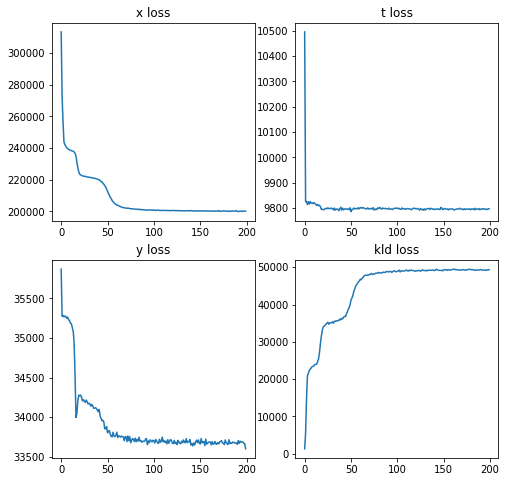

Total loss in the end:  292787.51025390625
Estimated causal effect: [0.02117983 0.87348616] true value: [0, 0.5]


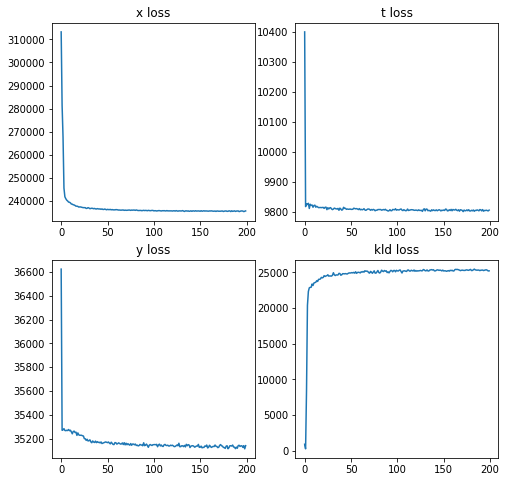

Total loss in the end:  305789.1767578125
Estimated causal effect: [0.02610704 0.83682454] true value: [0, 0.5]


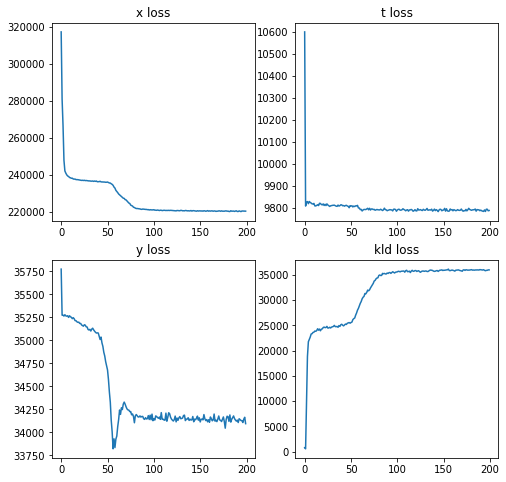

Total loss in the end:  300106.7204589844
Estimated causal effect: [0.01749246 0.8745749 ] true value: [0, 0.5]


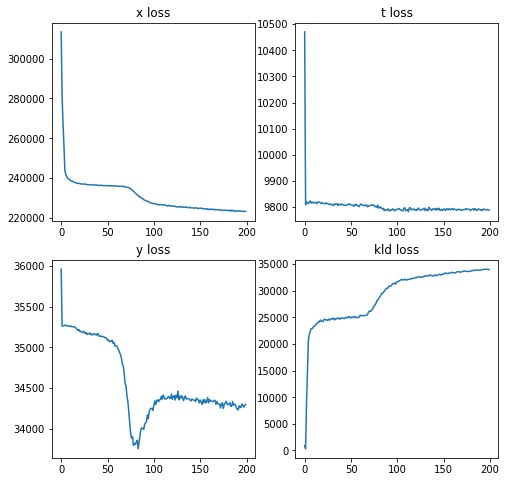

Total loss in the end:  301344.23779296875
Estimated causal effect: [0.02368839 0.87469453] true value: [0, 0.5]


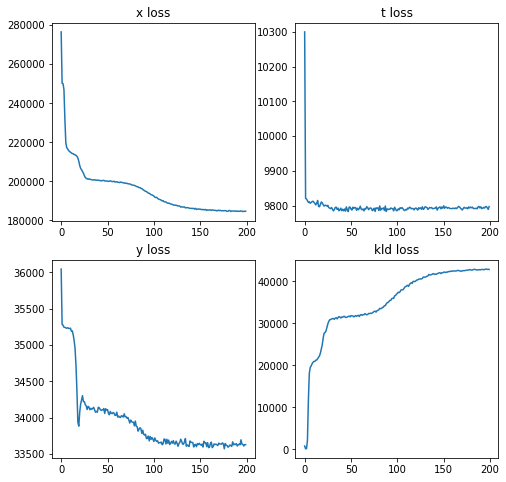

Total loss in the end:  271005.0744628906
Estimated causal effect: [0.02301323 0.87683111] true value: [0, 0.5]


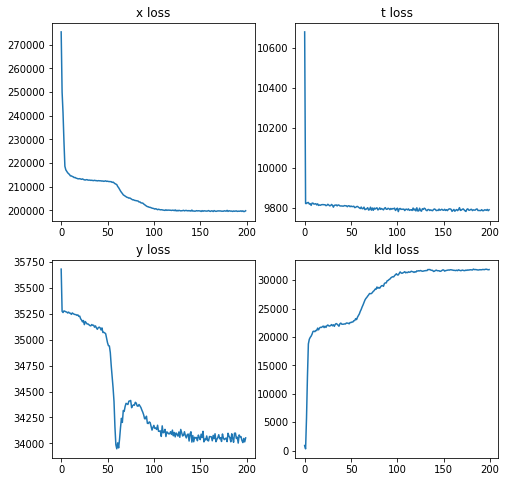

Total loss in the end:  275581.02099609375
Estimated causal effect: [0.01808927 0.87560999] true value: [0, 0.5]


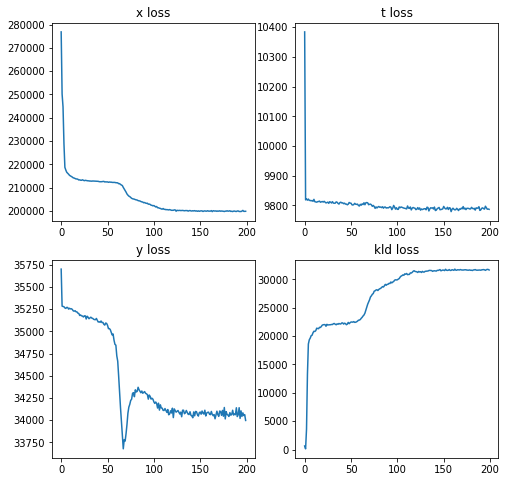

Total loss in the end:  275303.8095703125
Estimated causal effect: [0.01834442 0.87273031] true value: [0, 0.5]


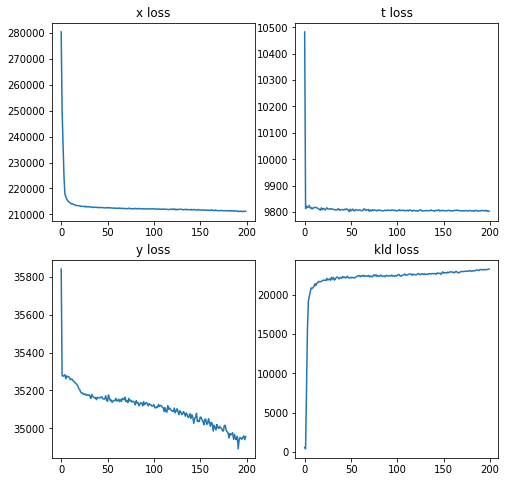

Total loss in the end:  279238.8937988281
Estimated causal effect: [0.02555182 0.83990318] true value: [0, 0.5]


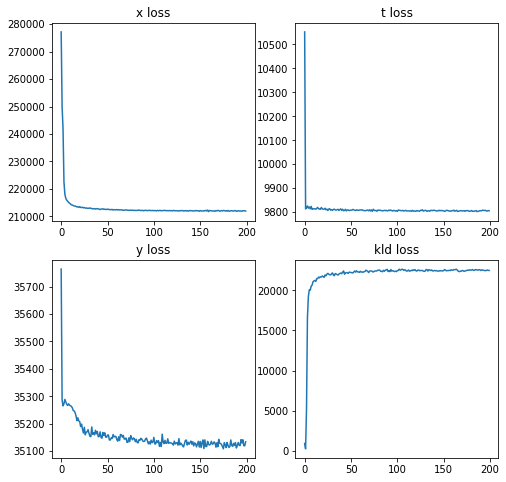

Total loss in the end:  279336.17919921875
Estimated causal effect: [0.0260792 0.8377021] true value: [0, 0.5]


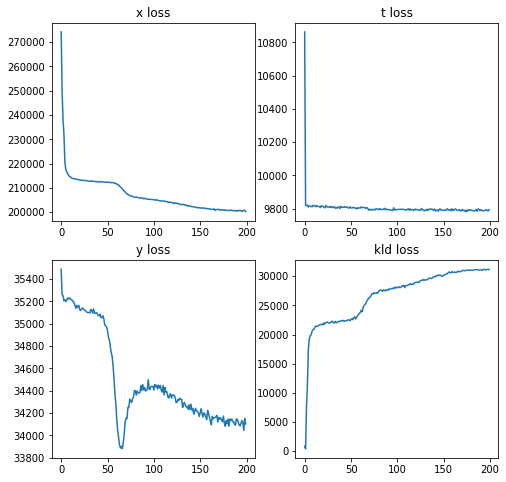

Total loss in the end:  275257.2390136719
Estimated causal effect: [0.02140438 0.87462288] true value: [0, 0.5]


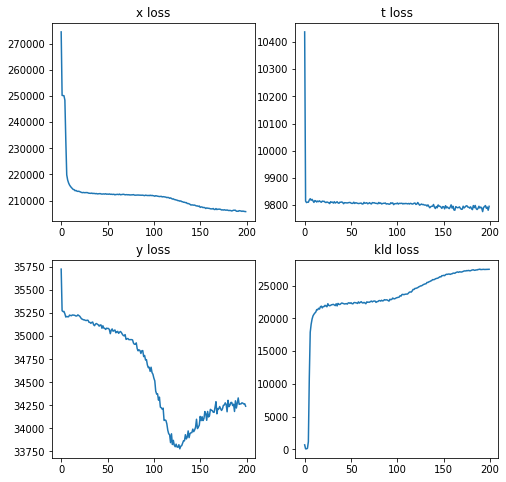

Total loss in the end:  277290.4729003906
Estimated causal effect: [0.01760896 0.86674142] true value: [0, 0.5]


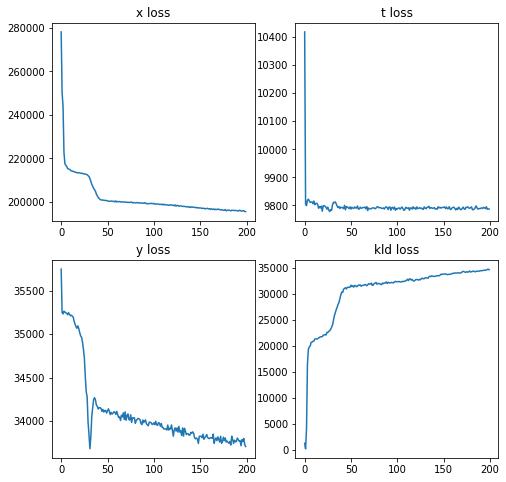

Total loss in the end:  273715.6970214844
Estimated causal effect: [0.02004777 0.87694556] true value: [0, 0.5]


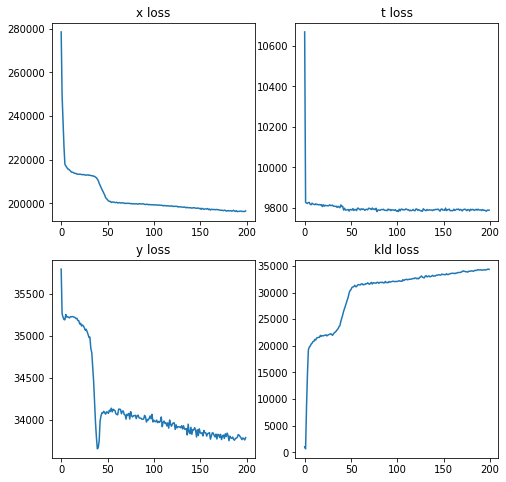

Total loss in the end:  274471.34814453125
Estimated causal effect: [0.01914478 0.87644345] true value: [0, 0.5]


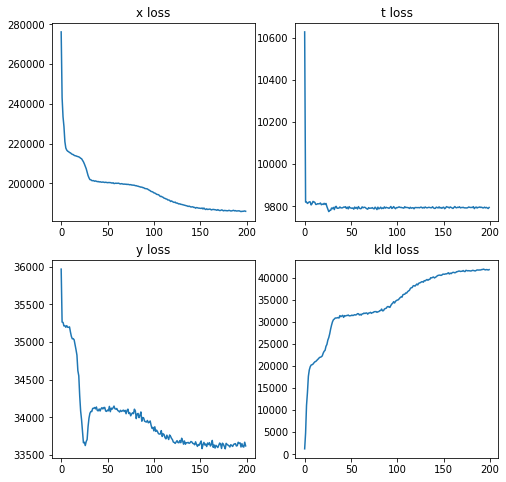

Total loss in the end:  271111.599609375
Estimated causal effect: [0.01807982 0.86669719] true value: [0, 0.5]


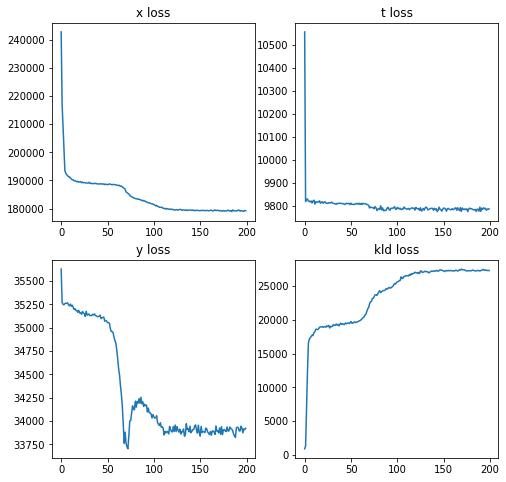

Total loss in the end:  250216.9951171875
Estimated causal effect: [0.0157996  0.87774873] true value: [0, 0.5]


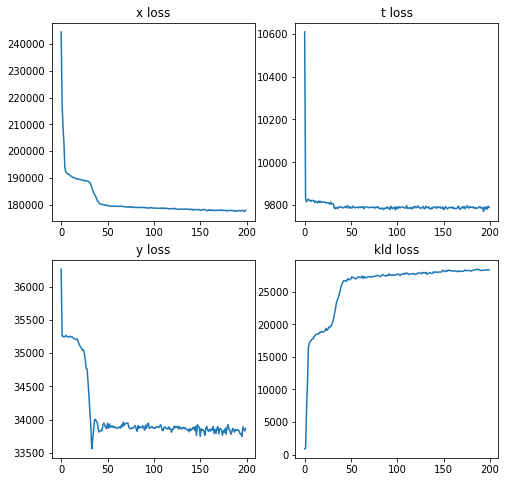

Total loss in the end:  250056.31225585938
Estimated causal effect: [0.01830915 0.87924916] true value: [0, 0.5]


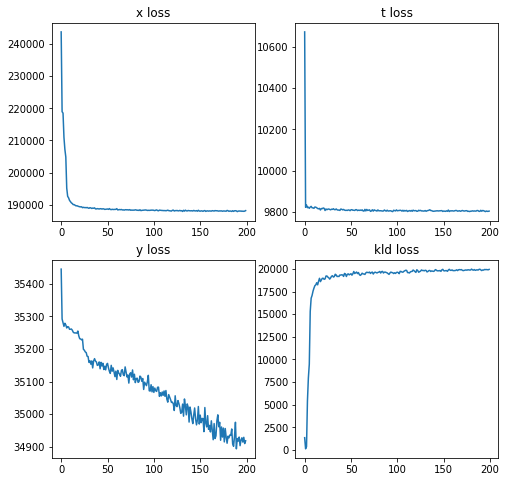

Total loss in the end:  252877.5029296875
Estimated causal effect: [0.02656871 0.83815217] true value: [0, 0.5]


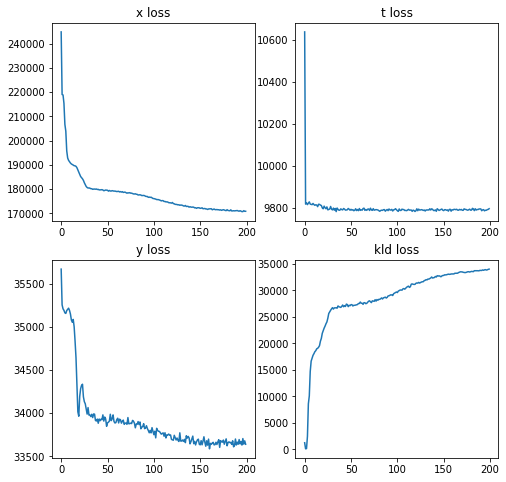

Total loss in the end:  248289.30908203125
Estimated causal effect: [0.01389222 0.8704139 ] true value: [0, 0.5]


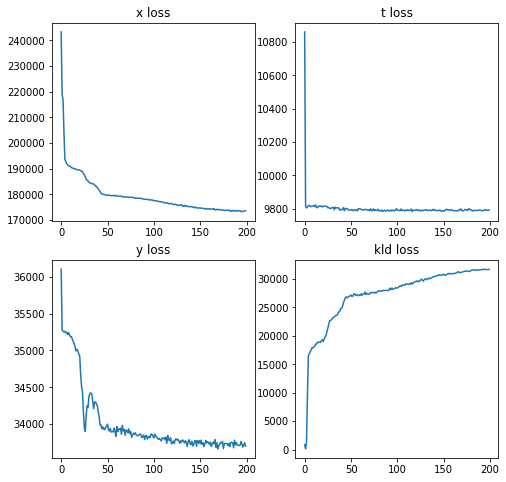

Total loss in the end:  248760.57788085938
Estimated causal effect: [0.01628501 0.87217826] true value: [0, 0.5]


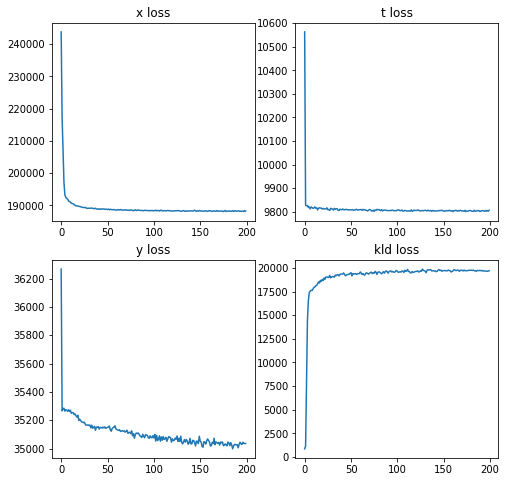

Total loss in the end:  252749.13208007812
Estimated causal effect: [0.02520259 0.83577883] true value: [0, 0.5]


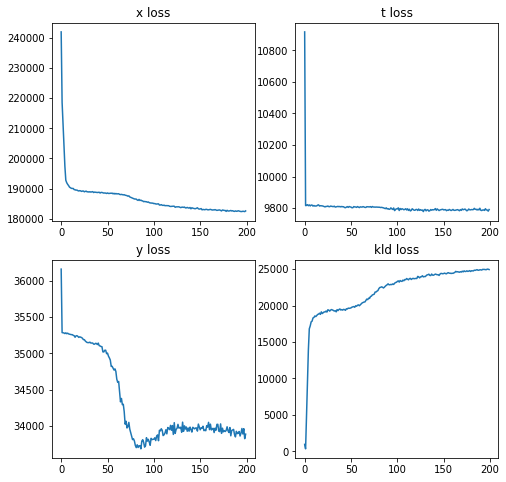

Total loss in the end:  251182.58349609375
Estimated causal effect: [0.02073129 0.8788628 ] true value: [0, 0.5]


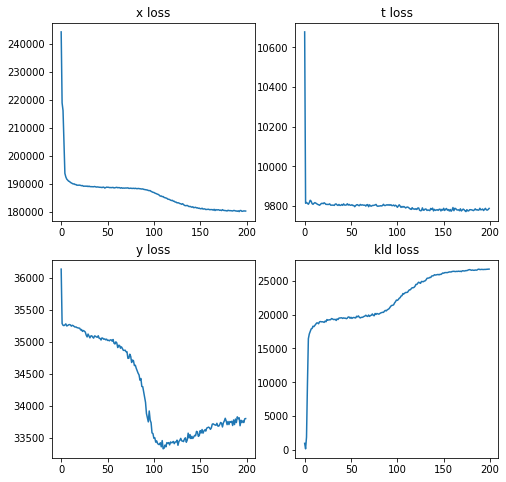

Total loss in the end:  250492.66943359375
Estimated causal effect: [0.01547759 0.88466233] true value: [0, 0.5]


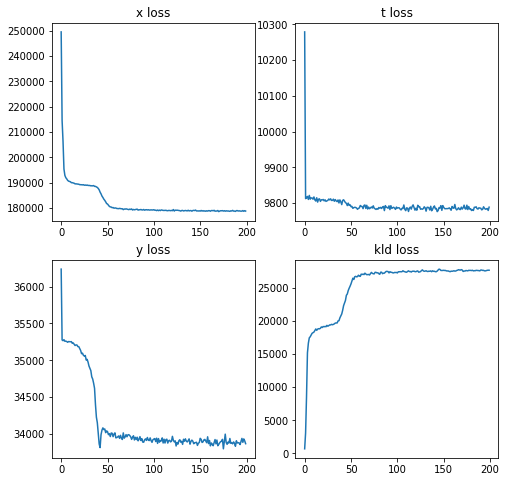

Total loss in the end:  250083.11352539062
Estimated causal effect: [0.01683054 0.88091391] true value: [0, 0.5]


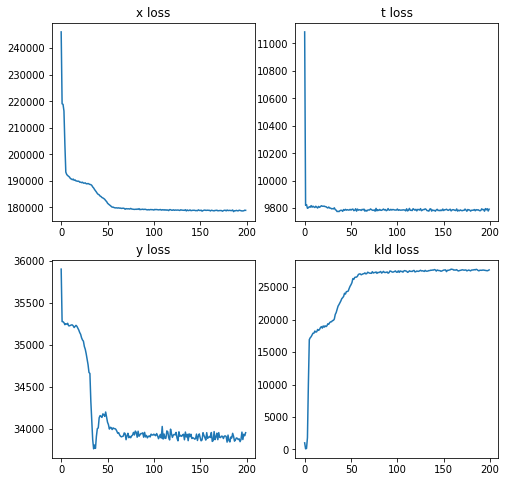

Total loss in the end:  250267.97119140625
Estimated causal effect: [0.01871896 0.87578654] true value: [0, 0.5]


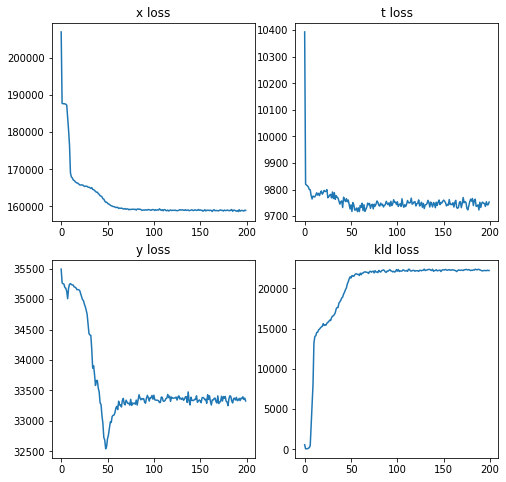

Total loss in the end:  224176.83447265625
Estimated causal effect: [0.0124105  0.88439643] true value: [0, 0.5]


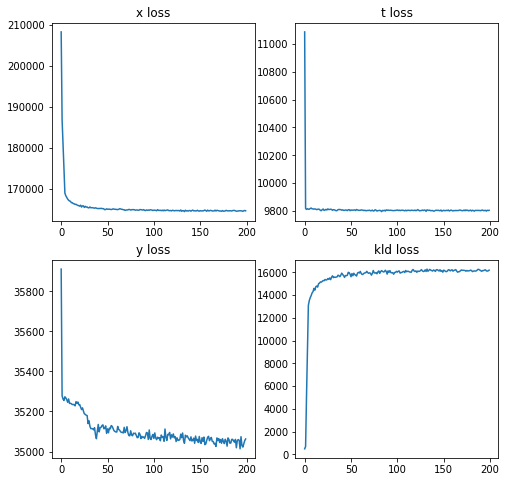

Total loss in the end:  225735.96313476562
Estimated causal effect: [0.02564001 0.83635139] true value: [0, 0.5]


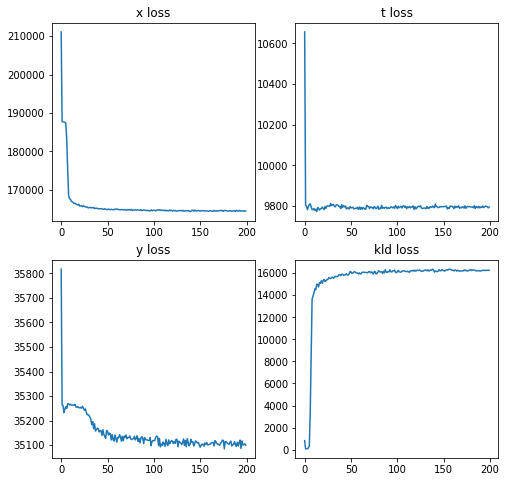

Total loss in the end:  225660.88549804688
Estimated causal effect: [0.02549657 0.83696967] true value: [0, 0.5]


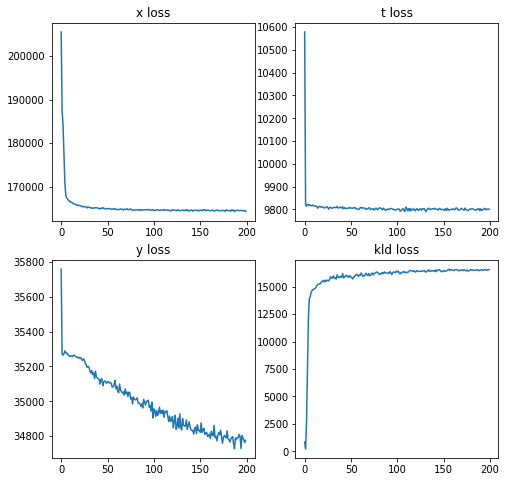

Total loss in the end:  225397.33911132812
Estimated causal effect: [0.02535078 0.83772063] true value: [0, 0.5]


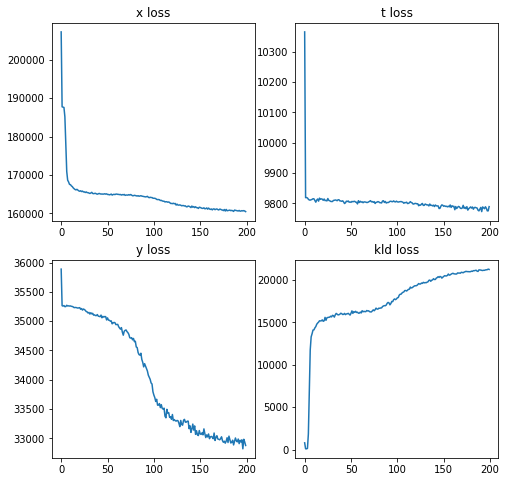

Total loss in the end:  224344.6767578125
Estimated causal effect: [0.01220537 0.89225495] true value: [0, 0.5]


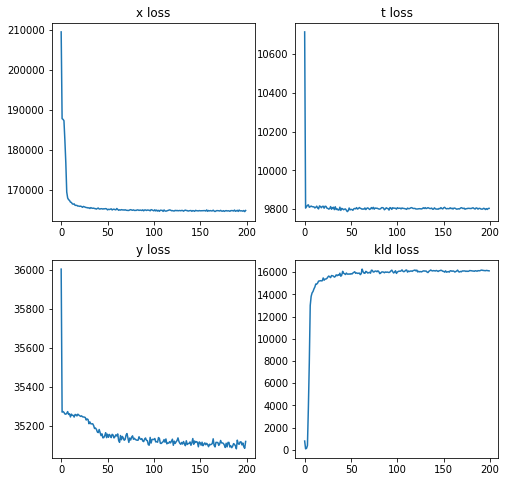

Total loss in the end:  225811.115234375
Estimated causal effect: [0.02487602 0.83655417] true value: [0, 0.5]


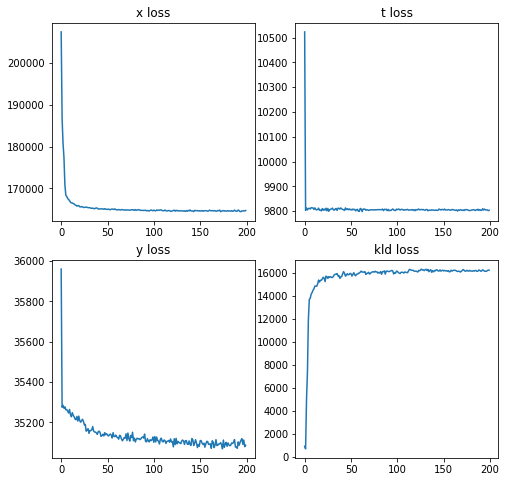

Total loss in the end:  225827.13842773438
Estimated causal effect: [0.0263349  0.83674628] true value: [0, 0.5]


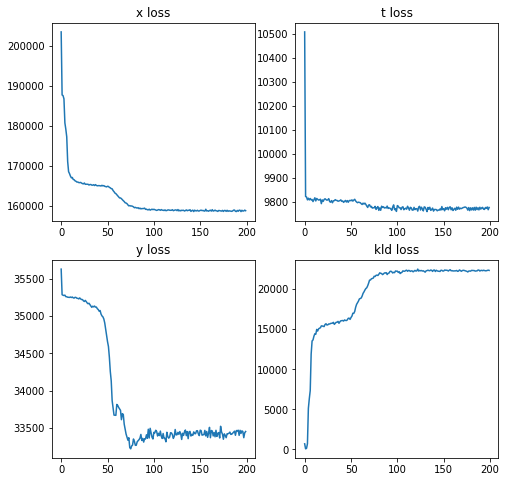

Total loss in the end:  224308.03100585938
Estimated causal effect: [0.01265379 0.89079088] true value: [0, 0.5]


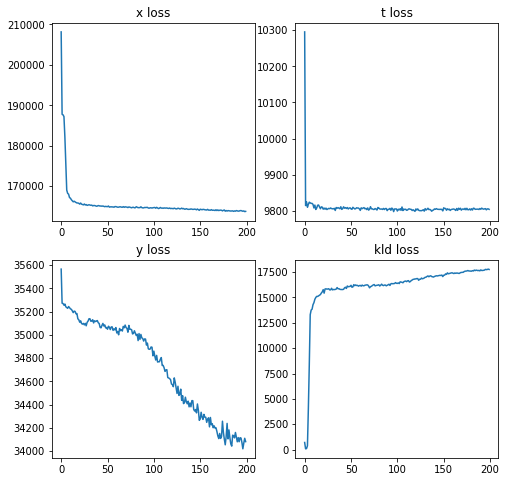

Total loss in the end:  225354.51806640625
Estimated causal effect: [0.02530924 0.84136224] true value: [0, 0.5]


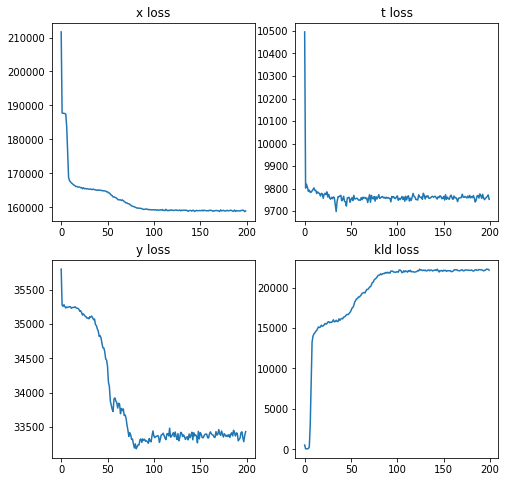

Total loss in the end:  224293.26220703125
Estimated causal effect: [0.01072974 0.8960728 ] true value: [0, 0.5]


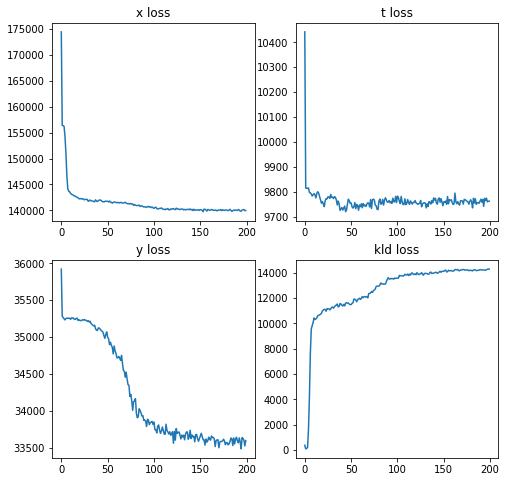

Total loss in the end:  197623.2305908203
Estimated causal effect: [0.01491122 0.88897955] true value: [0, 0.5]


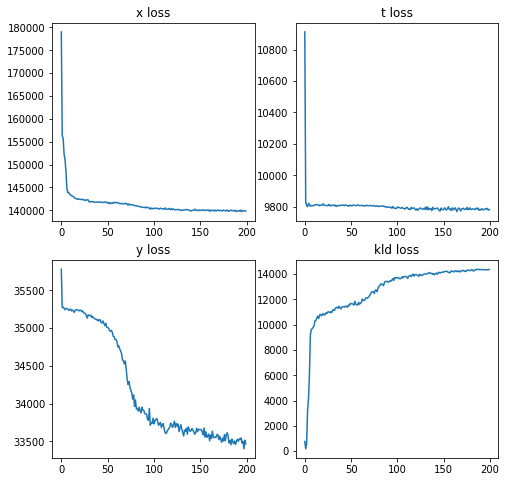

Total loss in the end:  197468.224609375
Estimated causal effect: [0.01876425 0.89204752] true value: [0, 0.5]


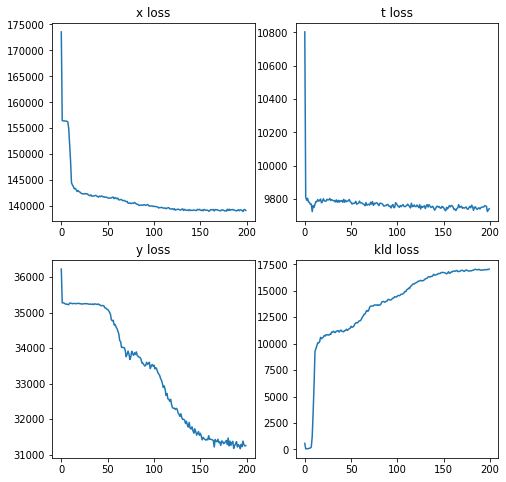

Total loss in the end:  197182.21850585938
Estimated causal effect: [0.00403297 0.93078393] true value: [0, 0.5]


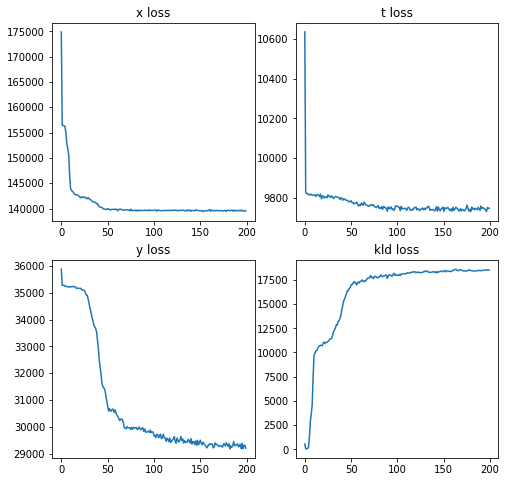

Total loss in the end:  196971.26196289062
Estimated causal effect: [-0.01083821  0.98477846] true value: [0, 0.5]


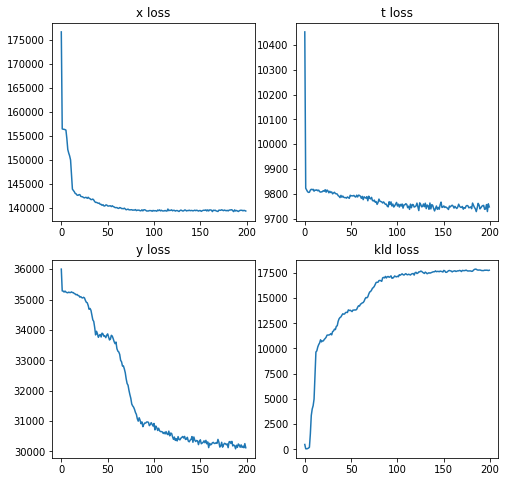

Total loss in the end:  196976.837890625
Estimated causal effect: [-0.00633996  0.97340047] true value: [0, 0.5]


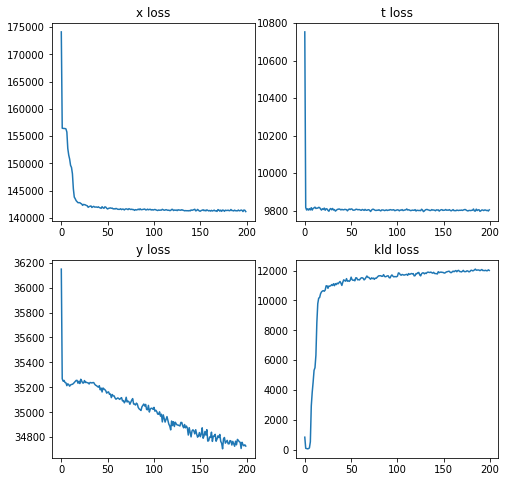

Total loss in the end:  197682.57946777344
Estimated causal effect: [0.02265881 0.83999377] true value: [0, 0.5]


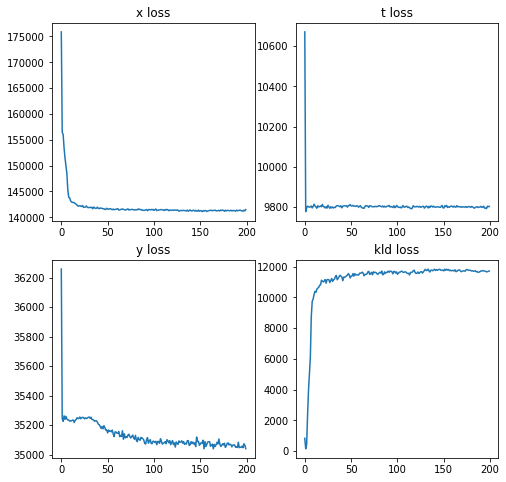

Total loss in the end:  198055.34704589844
Estimated causal effect: [0.02540385 0.83598596] true value: [0, 0.5]


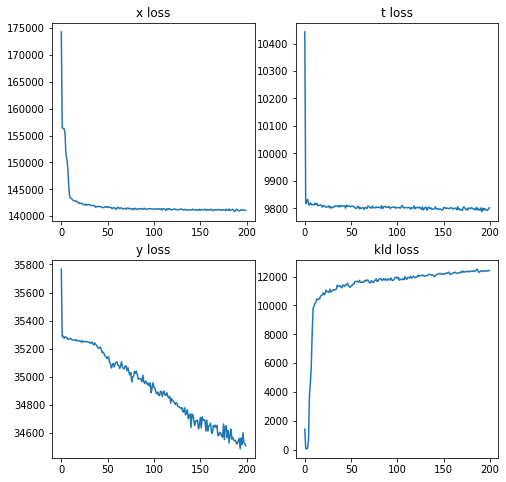

Total loss in the end:  197758.7100830078
Estimated causal effect: [0.02157949 0.85372704] true value: [0, 0.5]


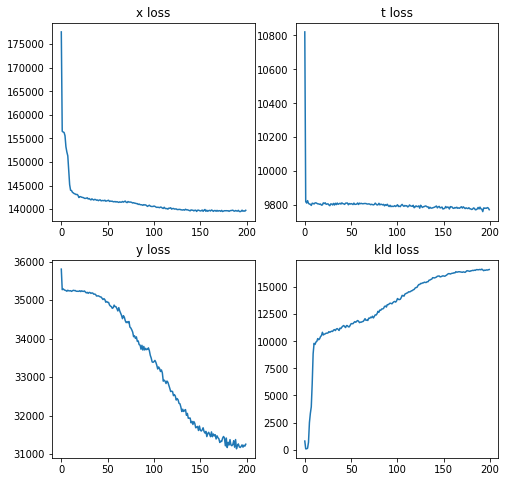

Total loss in the end:  197415.6707763672
Estimated causal effect: [0.00818852 0.91626859] true value: [0, 0.5]


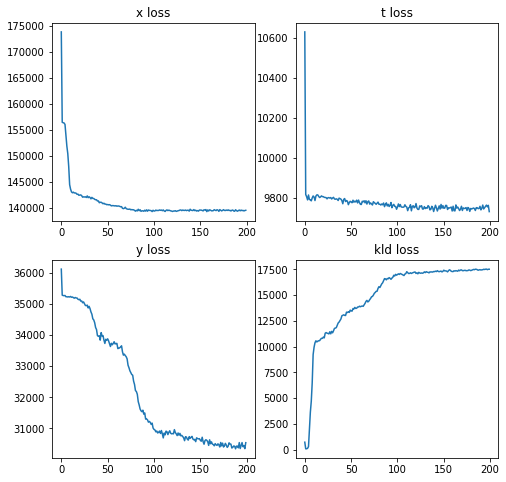

Total loss in the end:  197328.37951660156
Estimated causal effect: [-0.00699154  0.96273953] true value: [0, 0.5]


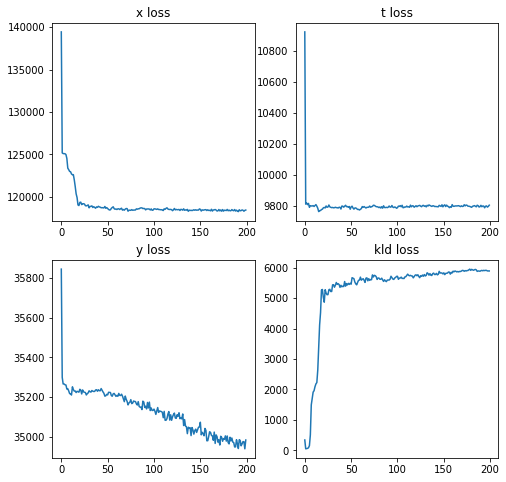

Total loss in the end:  169121.51733398438
Estimated causal effect: [0.02605264 0.84262133] true value: [0, 0.5]


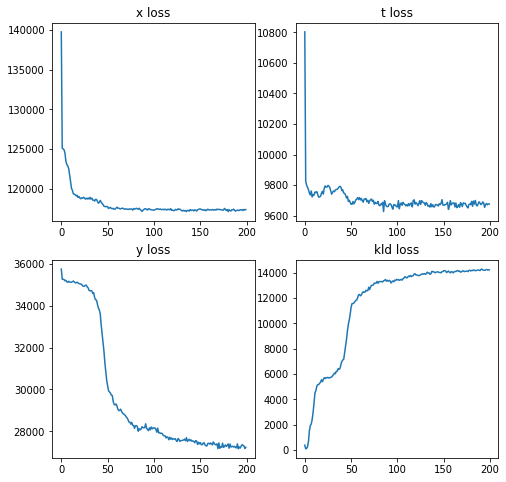

Total loss in the end:  168535.6727294922
Estimated causal effect: [-0.01423091  1.02417433] true value: [0, 0.5]


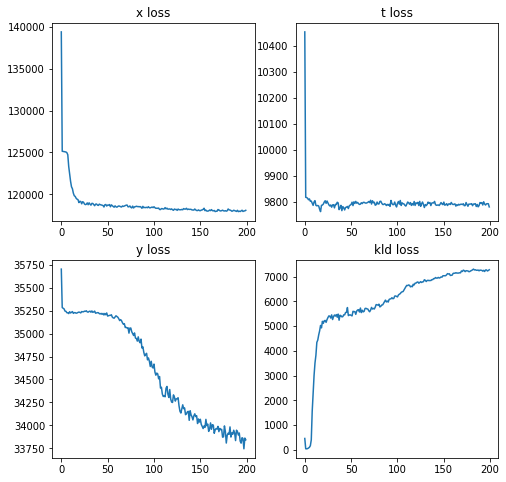

Total loss in the end:  168997.0106201172
Estimated causal effect: [0.01987893 0.86770815] true value: [0, 0.5]


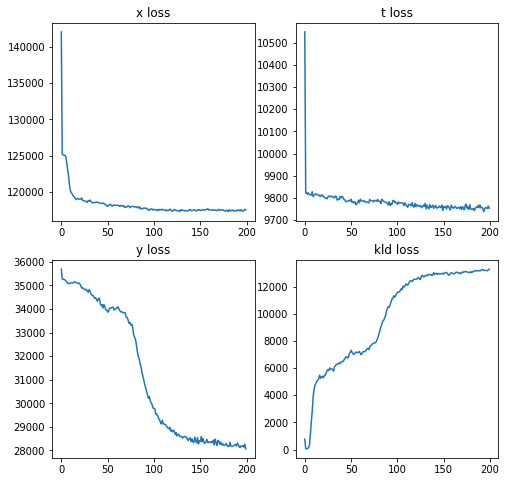

Total loss in the end:  168605.396484375
Estimated causal effect: [-0.00807506  0.97227609] true value: [0, 0.5]


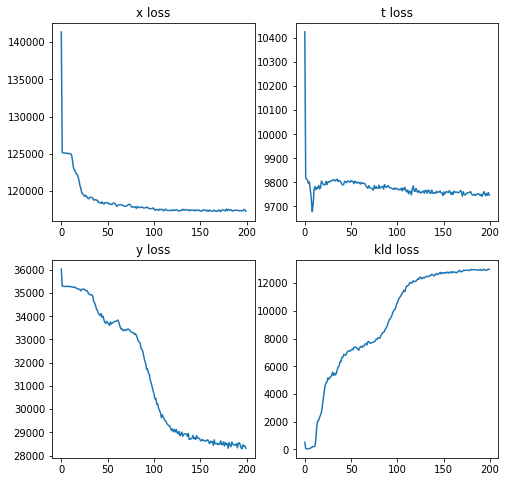

Total loss in the end:  168340.3212890625
Estimated causal effect: [-0.00959681  0.98100185] true value: [0, 0.5]


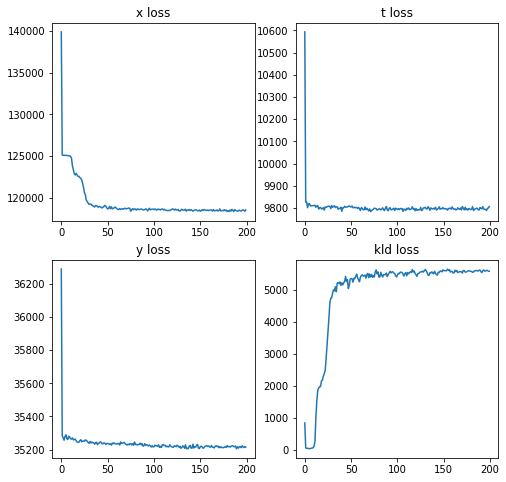

Total loss in the end:  169175.49731445312
Estimated causal effect: [0.02683429 0.83571595] true value: [0, 0.5]


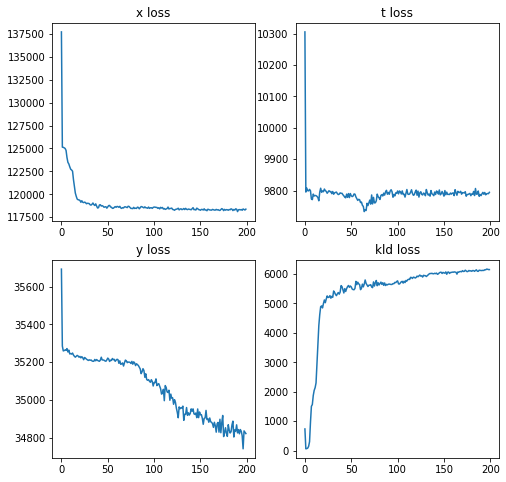

Total loss in the end:  169140.99743652344
Estimated causal effect: [0.02318122 0.85296679] true value: [0, 0.5]


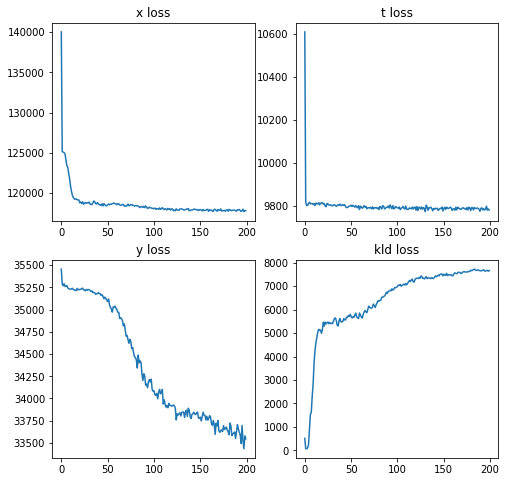

Total loss in the end:  168834.63989257812
Estimated causal effect: [0.01676004 0.87466288] true value: [0, 0.5]


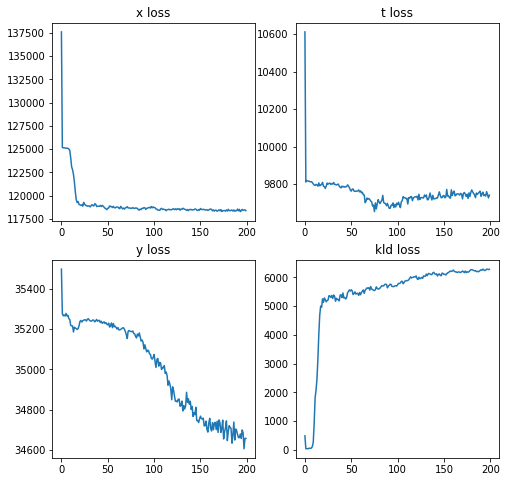

Total loss in the end:  169055.74829101562
Estimated causal effect: [0.02052104 0.85522747] true value: [0, 0.5]


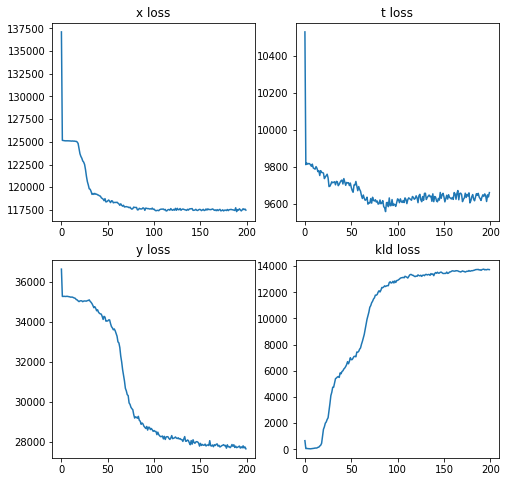

Total loss in the end:  168510.1328125
Estimated causal effect: [-0.02370705  1.05450845] true value: [0, 0.5]


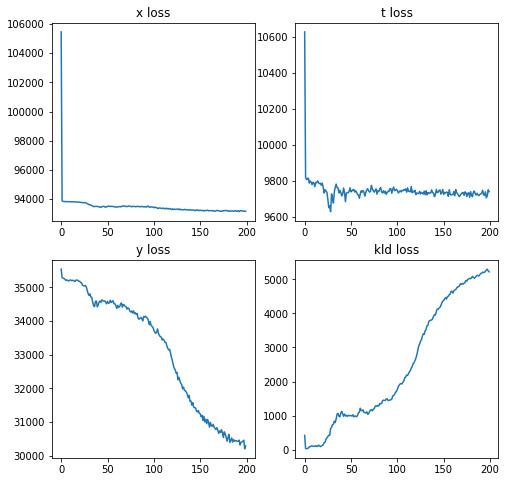

Total loss in the end:  138414.02282714844
Estimated causal effect: [0.00930896 0.89823252] true value: [0, 0.5]


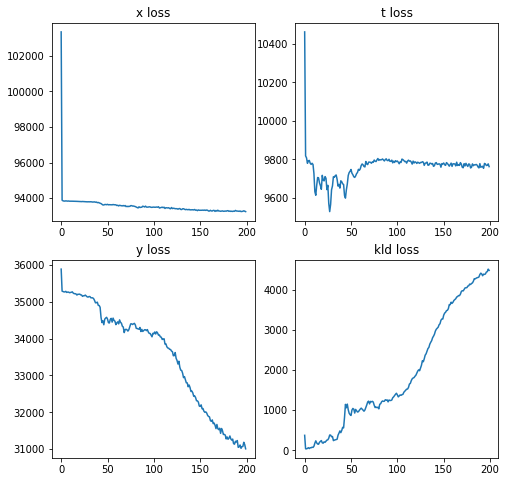

Total loss in the end:  138495.8963623047
Estimated causal effect: [0.00558509 0.92076737] true value: [0, 0.5]


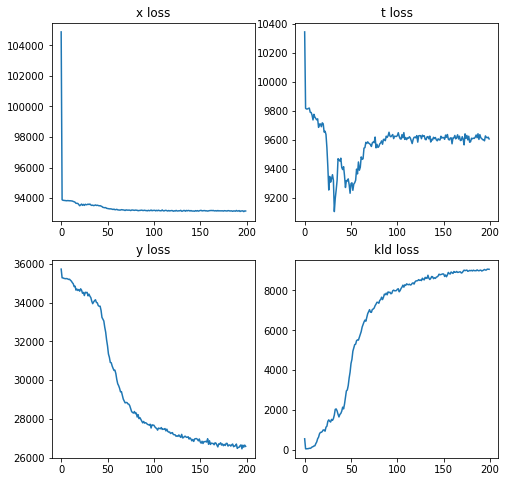

Total loss in the end:  138417.28479003906
Estimated causal effect: [-0.03632003  1.08505261] true value: [0, 0.5]


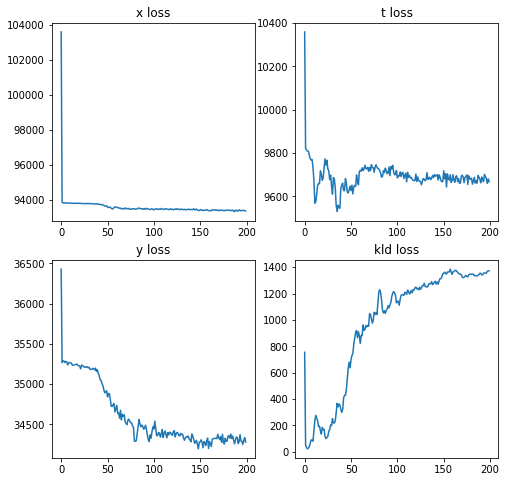

Total loss in the end:  138703.4571533203
Estimated causal effect: [0.02001816 0.86157602] true value: [0, 0.5]


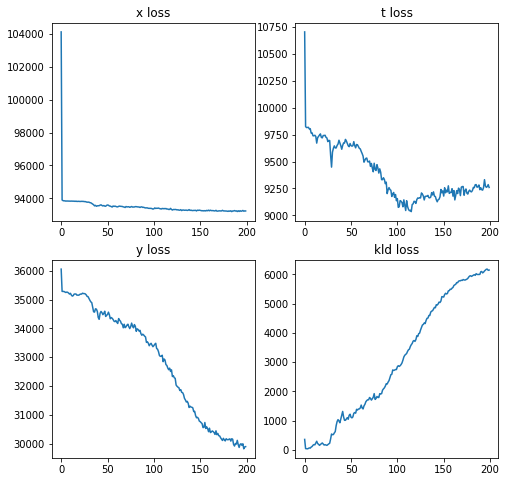

Total loss in the end:  138525.7293701172
Estimated causal effect: [-0.04165519  1.13061738] true value: [0, 0.5]


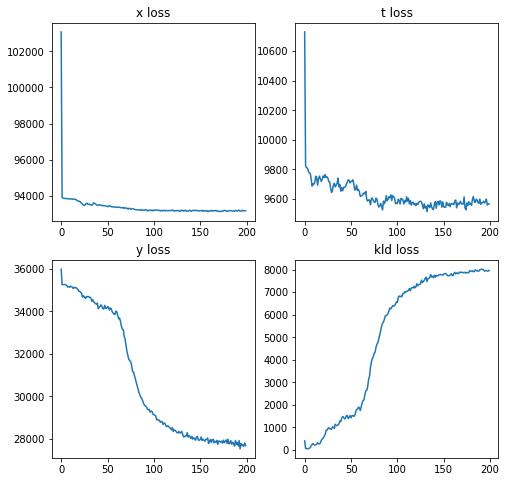

Total loss in the end:  138371.30786132812
Estimated causal effect: [-0.02659712  1.04142916] true value: [0, 0.5]


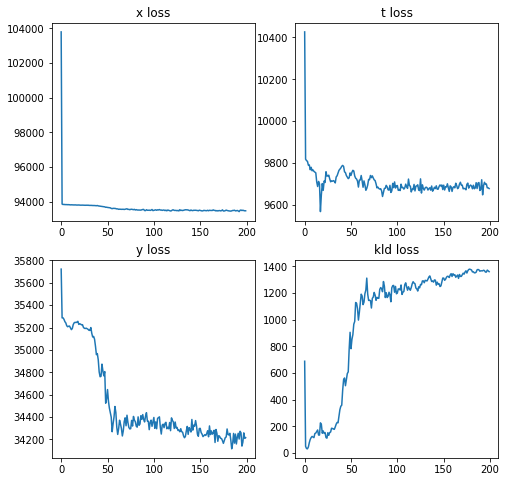

Total loss in the end:  138741.1485595703
Estimated causal effect: [0.01669541 0.86682284] true value: [0, 0.5]


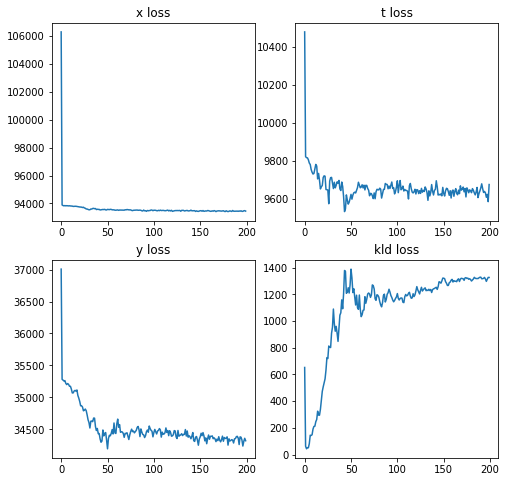

Total loss in the end:  138770.79858398438
Estimated causal effect: [0.02043961 0.86386842] true value: [0, 0.5]


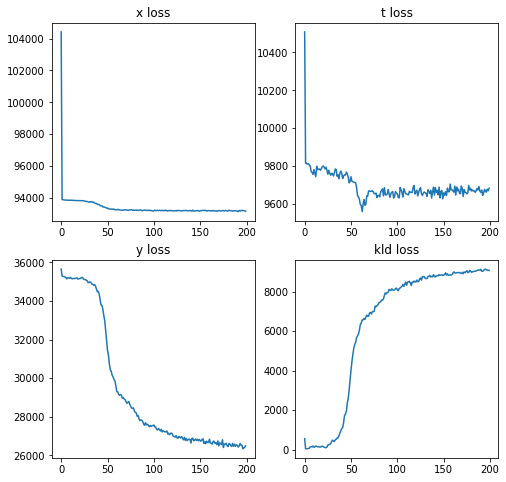

Total loss in the end:  138402.03649902344
Estimated causal effect: [-0.02219741  1.02816534] true value: [0, 0.5]


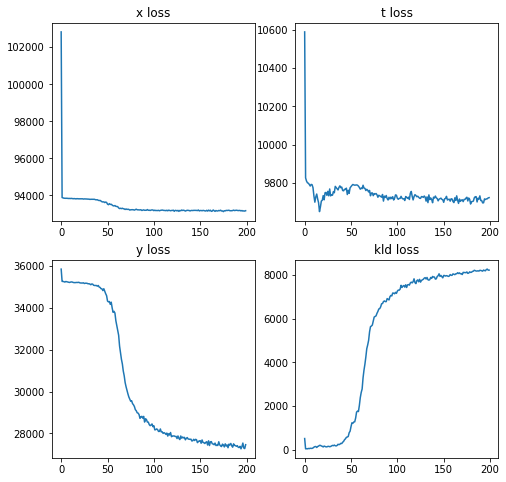

Total loss in the end:  138564.76599121094
Estimated causal effect: [-0.01214115  0.99294078] true value: [0, 0.5]


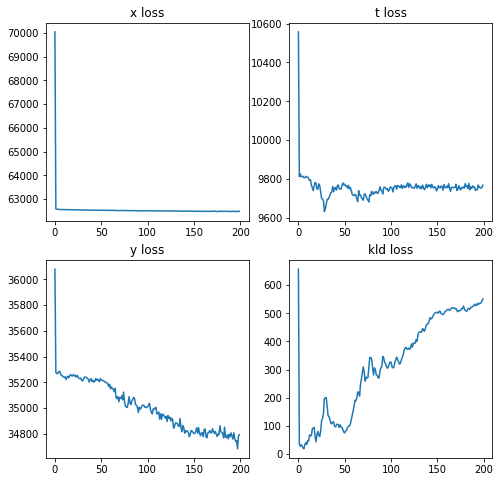

Total loss in the end:  107601.97131347656
Estimated causal effect: [0.02482265 0.84413725] true value: [0, 0.5]


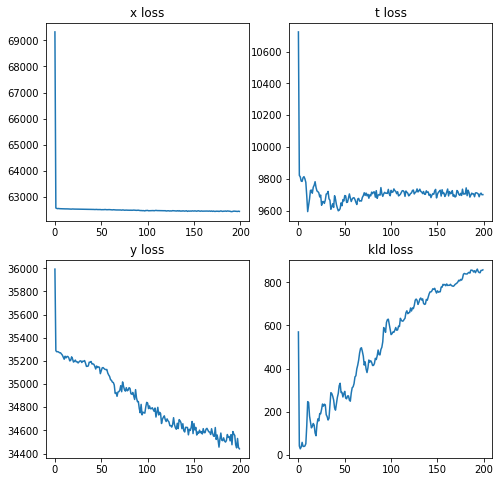

Total loss in the end:  107454.82299804688
Estimated causal effect: [0.02050339 0.86409086] true value: [0, 0.5]


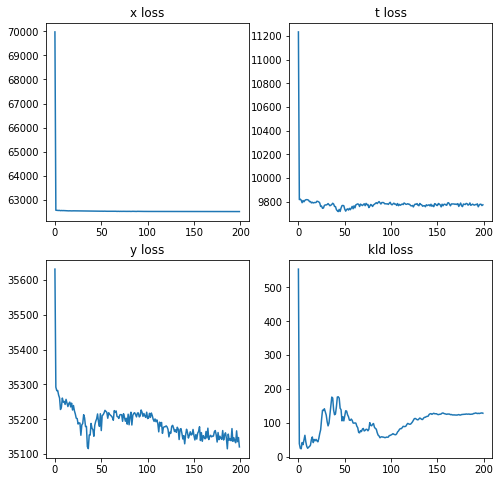

Total loss in the end:  107536.99450683594
Estimated causal effect: [0.02584807 0.84817588] true value: [0, 0.5]


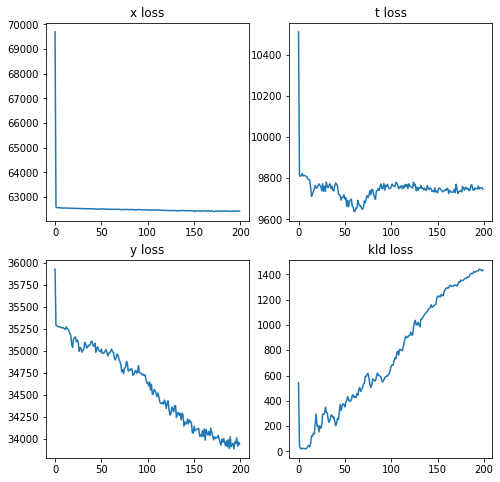

Total loss in the end:  107551.80017089844
Estimated causal effect: [0.01853224 0.8613165 ] true value: [0, 0.5]


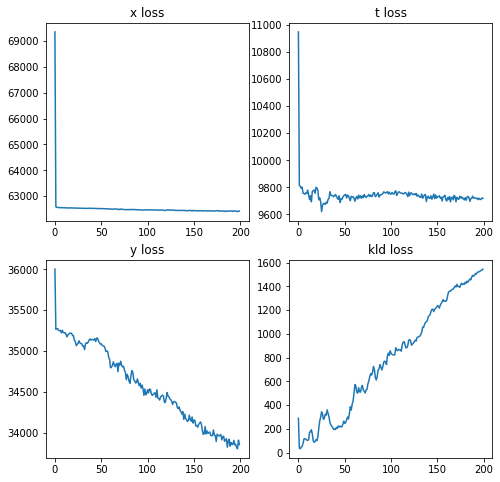

Total loss in the end:  107535.80688476562
Estimated causal effect: [0.00581072 0.88959569] true value: [0, 0.5]


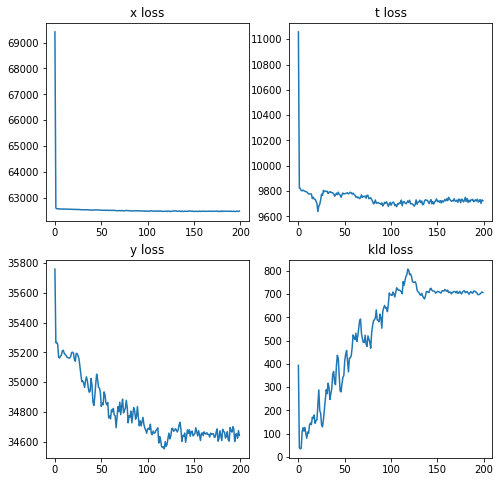

Total loss in the end:  107548.54125976562
Estimated causal effect: [0.02433783 0.85207063] true value: [0, 0.5]


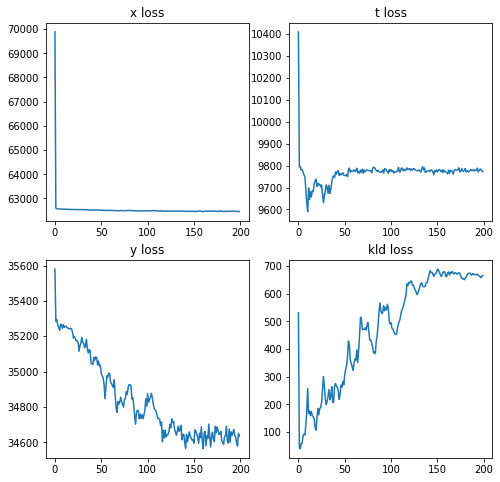

Total loss in the end:  107532.20678710938
Estimated causal effect: [0.02407582 0.8476333 ] true value: [0, 0.5]


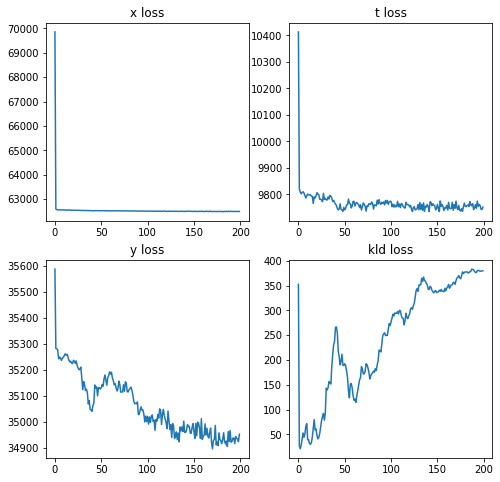

Total loss in the end:  107579.95556640625
Estimated causal effect: [0.02776561 0.83437508] true value: [0, 0.5]


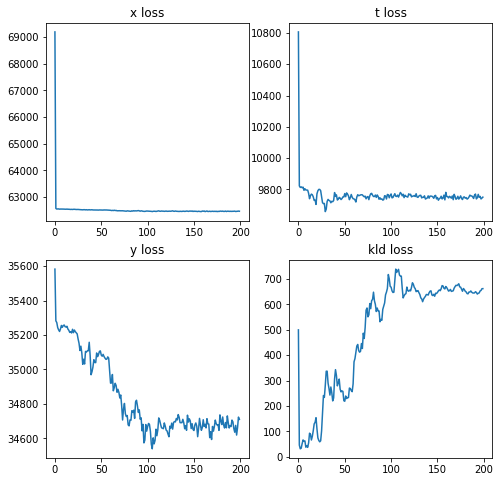

Total loss in the end:  107595.69519042969
Estimated causal effect: [0.02010987 0.8522256 ] true value: [0, 0.5]


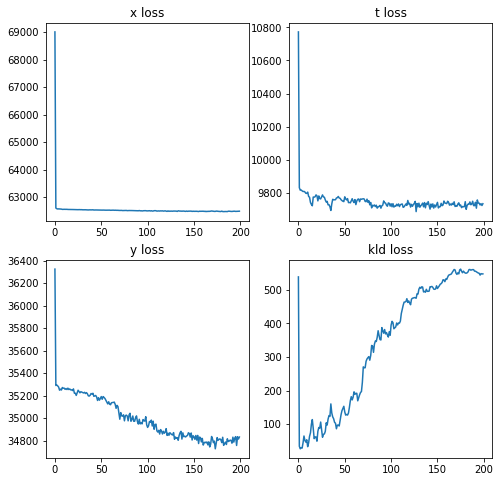

Total loss in the end:  107603.06384277344
Estimated causal effect: [0.02667413 0.843041  ] true value: [0, 0.5]


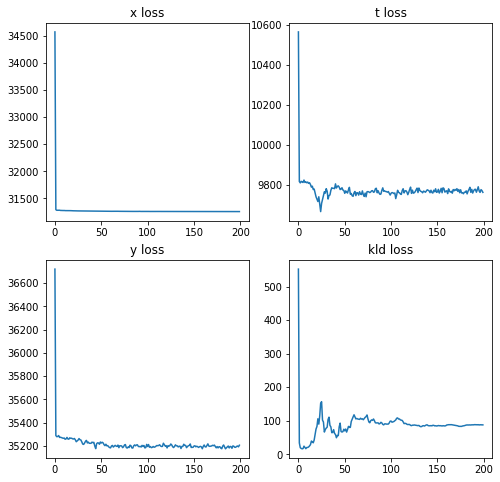

Total loss in the end:  76315.34448242188
Estimated causal effect: [0.0269976  0.83483517] true value: [0, 0.5]


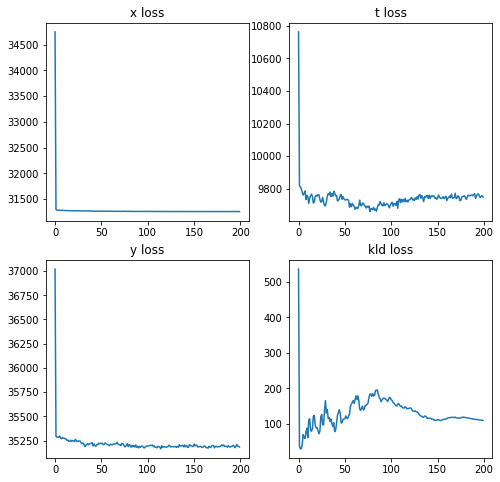

Total loss in the end:  76298.23858642578
Estimated causal effect: [0.02669489 0.83458495] true value: [0, 0.5]


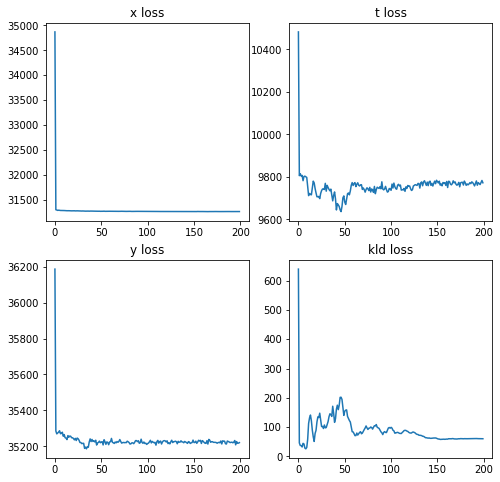

Total loss in the end:  76311.53137207031
Estimated causal effect: [0.02676723 0.83765286] true value: [0, 0.5]


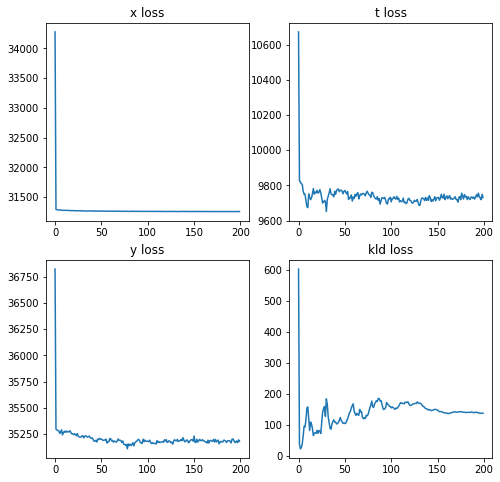

Total loss in the end:  76305.40808105469
Estimated causal effect: [0.02578441 0.84501666] true value: [0, 0.5]


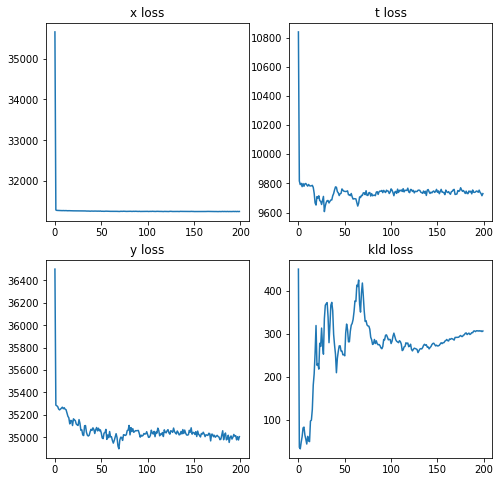

Total loss in the end:  76296.19720458984
Estimated causal effect: [0.02614103 0.83367729] true value: [0, 0.5]


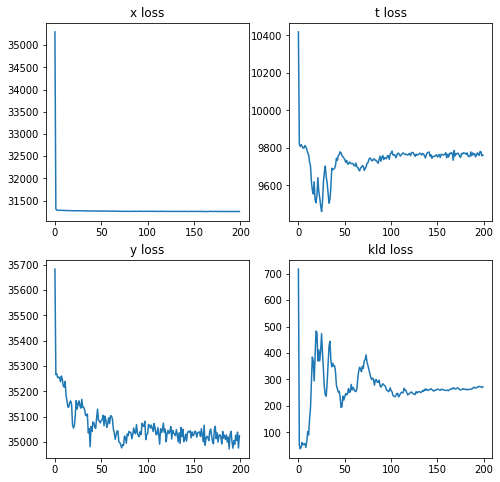

Total loss in the end:  76311.00952148438
Estimated causal effect: [0.03014896 0.81717712] true value: [0, 0.5]


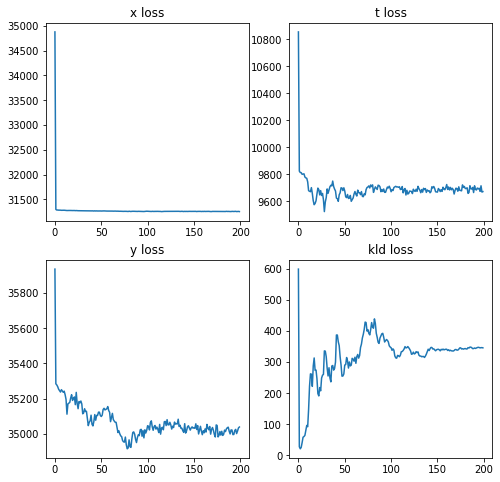

Total loss in the end:  76306.13885498047
Estimated causal effect: [0.02480924 0.84694999] true value: [0, 0.5]


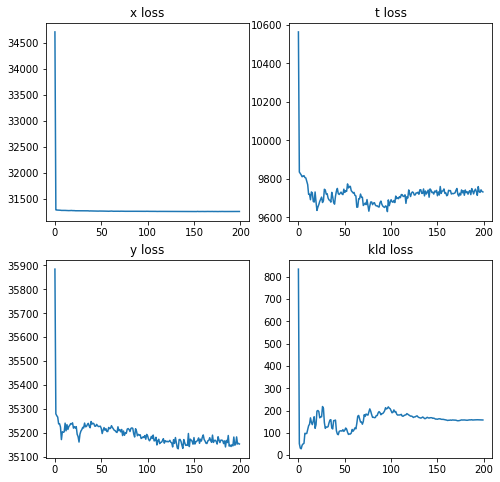

Total loss in the end:  76301.35577392578
Estimated causal effect: [0.02641772 0.83819151] true value: [0, 0.5]


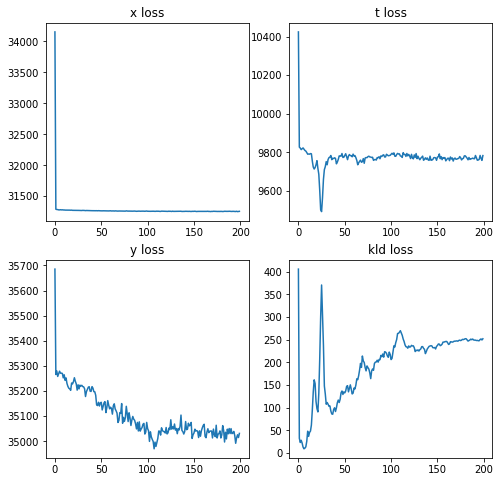

Total loss in the end:  76321.51916503906
Estimated causal effect: [0.02662357 0.83541125] true value: [0, 0.5]


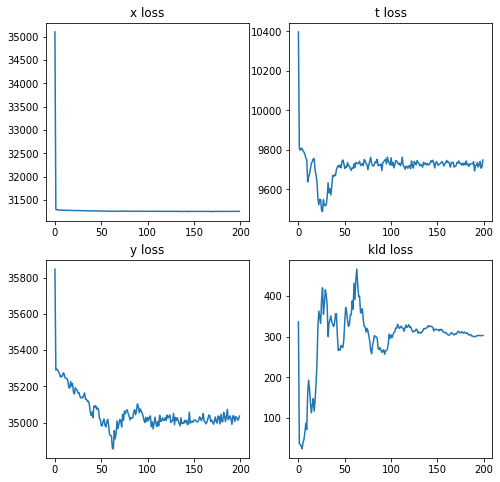

Total loss in the end:  76342.13305664062
Estimated causal effect: [0.02561021 0.84306175] true value: [0, 0.5]


In [311]:
# Run the model
models, losses = run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder_model, 
                                               BATCH_SIZE, track_function, true_value, 
                                               device, train_arguments, labels, data_labels)

# Tests on convergence without loss scaling

In [17]:
# Generate data sets
main_folder = "realdataz5"
sub_folder_data = "ATE1samplesize1000to20000"
ATE = 1
zvar_index = 5
datasize = [1000,2000,3000,5000,10000,15000,20000]
dataparameters = [[num_samples, proxymodel, model_zt, ATE, zvar_index] for num_samples in datasize]
generate_df = generatedata
param_times=10
data_labels = list(map(str, datasize))

In [315]:
dfs, datasets = create_dfs_datasets(generate_df, dataparameters, param_times=10, repeat=False, 
                    main_folder=main_folder, sub_folder=sub_folder_data, labels=data_labels)

In [18]:
dfs, datasets = load_dfs(main_folder, sub_folder_data, param_times)

## Run model

In [19]:
BATCH_SIZE = 200
track_function = lambda model: estimate_model_py_dot(model, 200000)
true_value = [0,0.5]
device = 'cpu'

num_epochs=200
lr_start=0.001
lr_end=0.00001
z_dim=10
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=30
q_z_nn_layers=3
q_z_nn_width=30
t_mode=2
y_mode=0
x_mode=np.delete(np.array([0]*3+[4]+[0]*2+[2]*(ihdp_x_train.shape[1]-6)),zvar_index)
x_dim = len(x_mode)
ty_separate_enc=True
z_mode=0
x_loss_scaling=1
labels = data_labels

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]

sub_folder_model = "ATE1zdim10samplesize1000to20000"

Creation of the directory './data/realdataz5/ATE1zdim10samplesize1000to20000/ failed. Trying to empty the same folder.


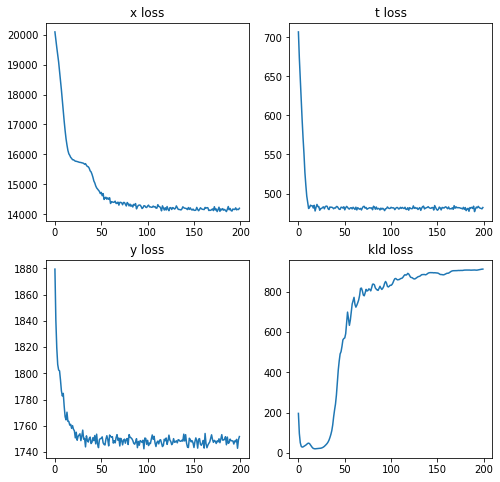

Total loss in the end:  17351.076904296875
Estimated causal effect: [-0.07499023  0.90927804] true value: [0, 0.5]


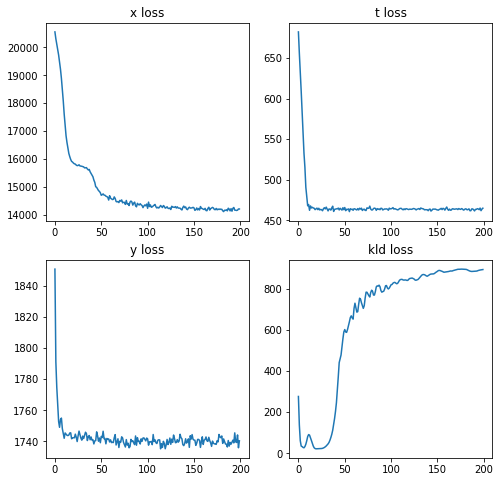

Total loss in the end:  17309.70947265625
Estimated causal effect: [0.08996853 0.77388954] true value: [0, 0.5]


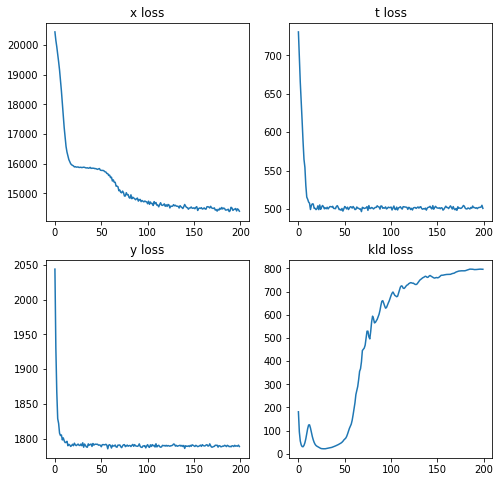

Total loss in the end:  17486.616943359375
Estimated causal effect: [0.0639801  0.88701475] true value: [0, 0.5]


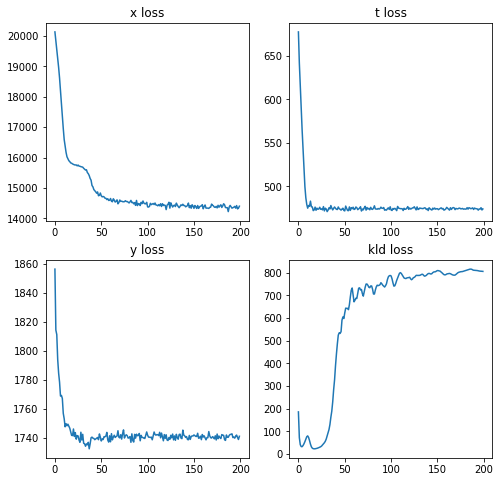

Total loss in the end:  17420.87890625
Estimated causal effect: [0.07402039 1.00999892] true value: [0, 0.5]


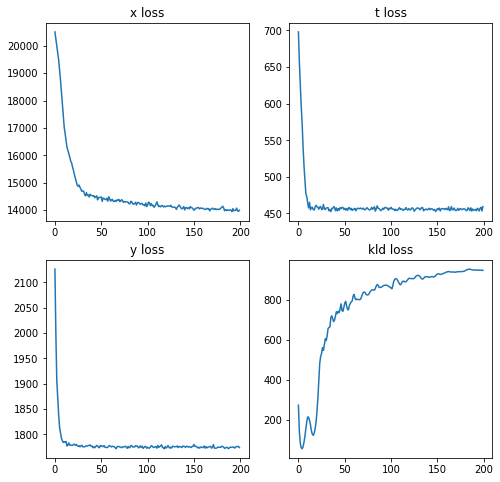

Total loss in the end:  17180.932861328125
Estimated causal effect: [0.01226386 0.68917626] true value: [0, 0.5]


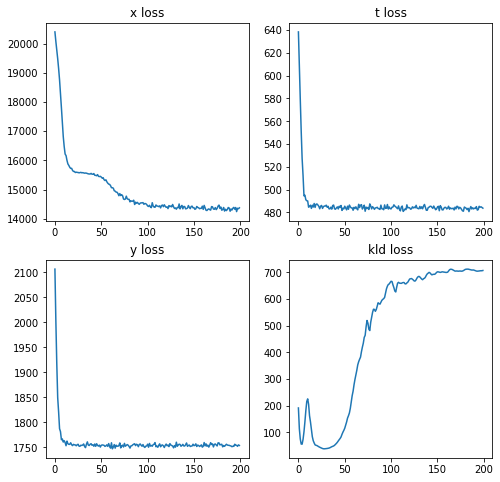

Total loss in the end:  17317.002197265625
Estimated causal effect: [0.11052512 0.77439952] true value: [0, 0.5]


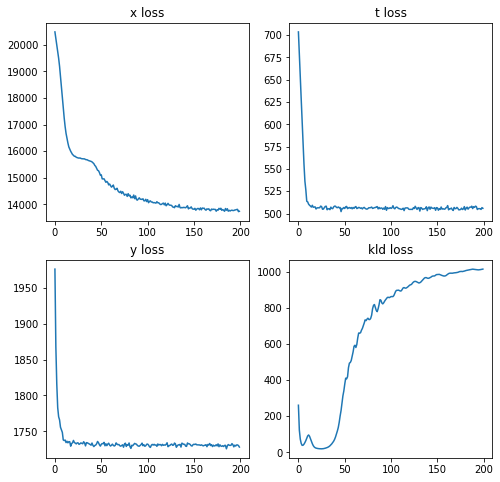

Total loss in the end:  16983.726318359375
Estimated causal effect: [0.05134083 0.86678112] true value: [0, 0.5]


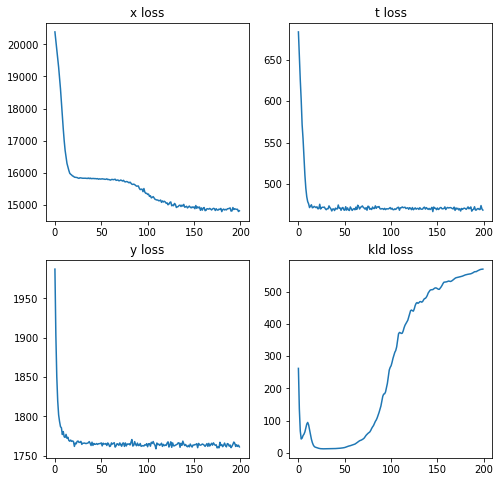

Total loss in the end:  17621.84765625
Estimated causal effect: [0.02106509 0.82104826] true value: [0, 0.5]


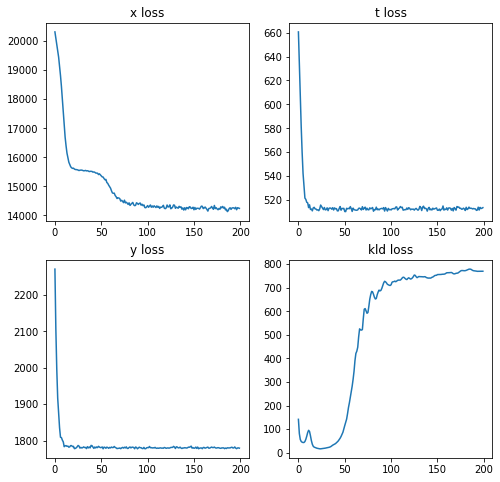

Total loss in the end:  17305.351806640625
Estimated causal effect: [0.09237523 0.82572216] true value: [0, 0.5]


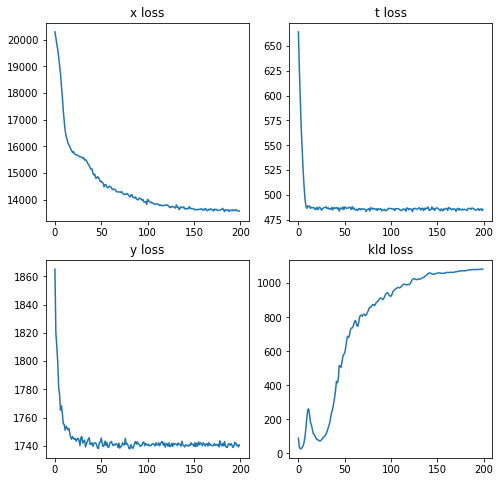

Total loss in the end:  16882.357177734375
Estimated causal effect: [-4.21488279e-04  9.71127212e-01] true value: [0, 0.5]


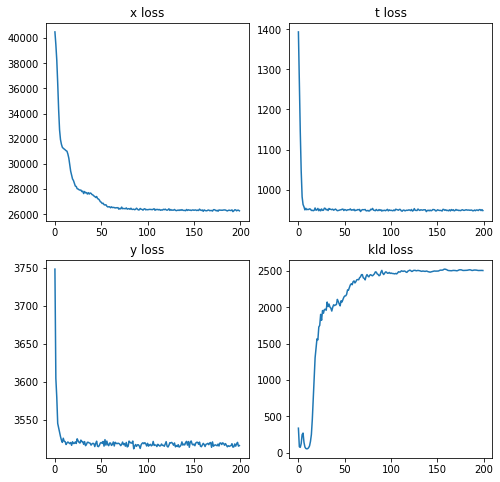

Total loss in the end:  33246.7451171875
Estimated causal effect: [0.07063907 0.93493867] true value: [0, 0.5]


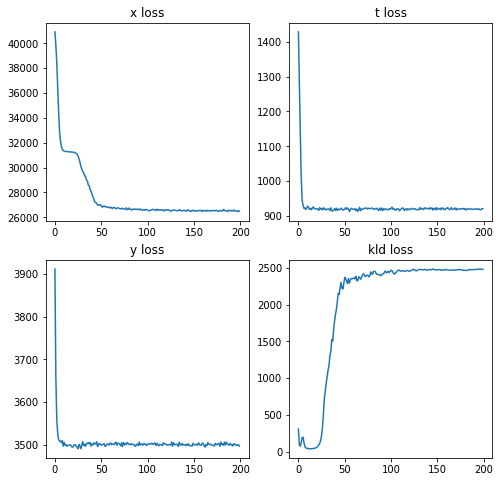

Total loss in the end:  33391.447998046875
Estimated causal effect: [0.00645879 0.89574236] true value: [0, 0.5]


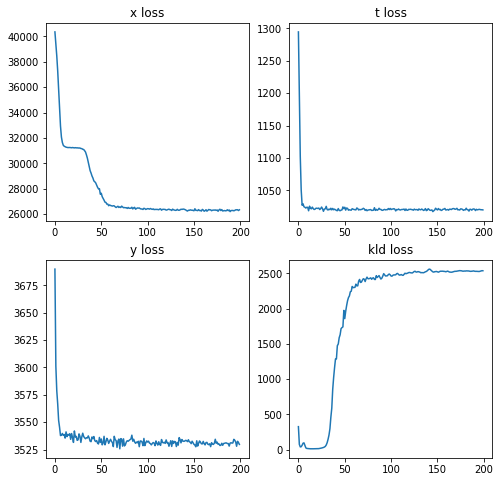

Total loss in the end:  33417.95654296875
Estimated causal effect: [0.05326513 0.90900636] true value: [0, 0.5]


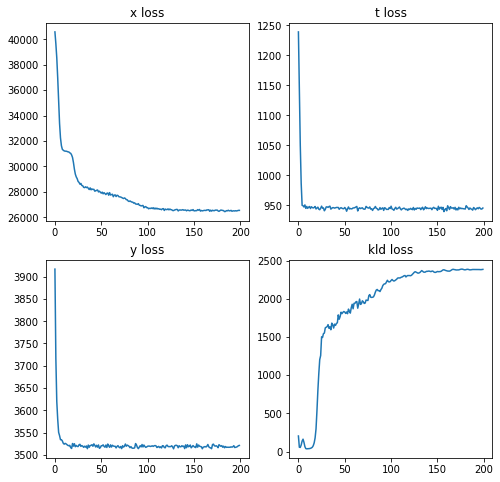

Total loss in the end:  33391.44873046875
Estimated causal effect: [0.03198174 0.96882671] true value: [0, 0.5]


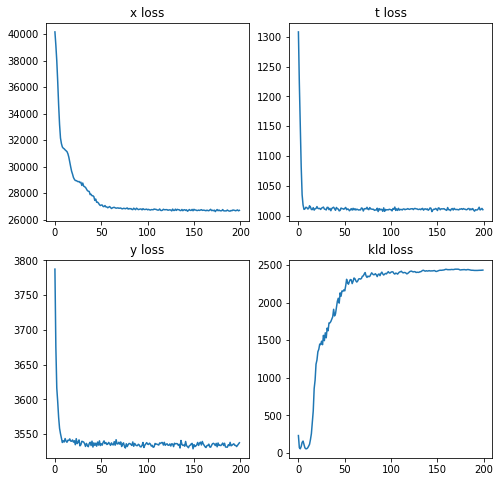

Total loss in the end:  33677.99658203125
Estimated causal effect: [0.06600892 0.87486225] true value: [0, 0.5]


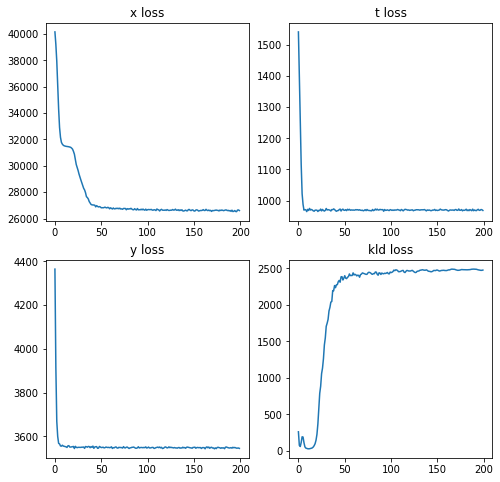

Total loss in the end:  33595.939208984375
Estimated causal effect: [-0.02513948  0.89322156] true value: [0, 0.5]


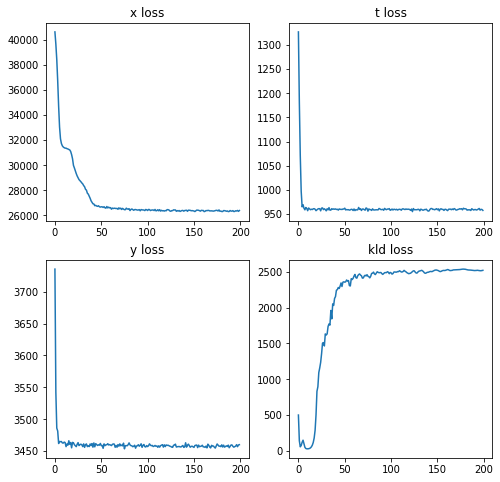

Total loss in the end:  33327.75
Estimated causal effect: [0.02897532 0.73360914] true value: [0, 0.5]


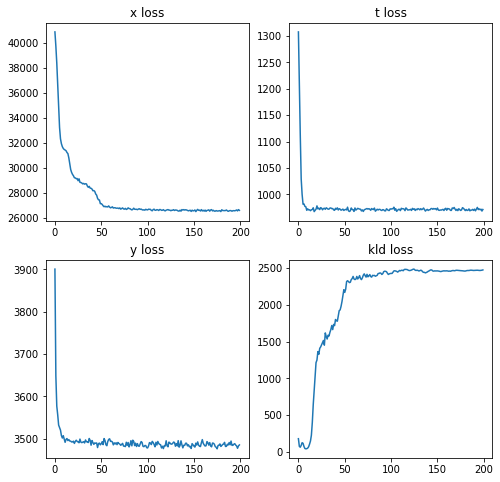

Total loss in the end:  33543.87841796875
Estimated causal effect: [-0.0280348   0.89874625] true value: [0, 0.5]


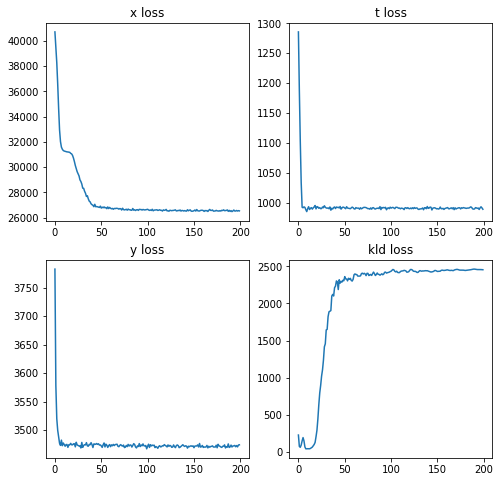

Total loss in the end:  33450.73291015625
Estimated causal effect: [-7.60871102e-04  8.96275461e-01] true value: [0, 0.5]


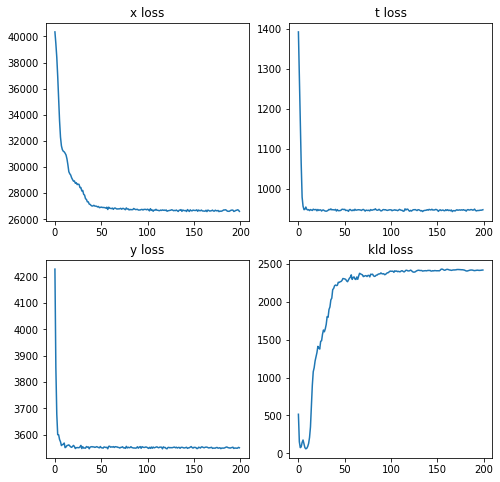

Total loss in the end:  33525.115966796875
Estimated causal effect: [0.05064279 0.85918158] true value: [0, 0.5]


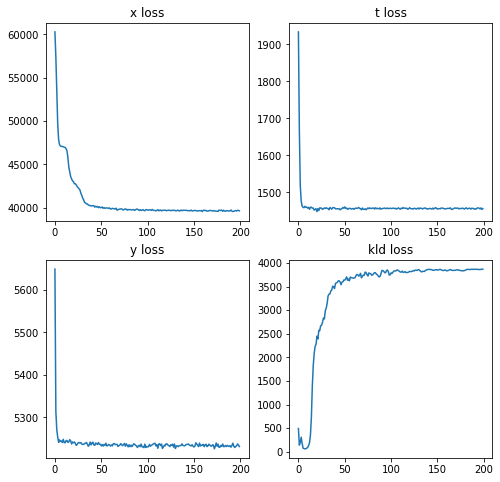

Total loss in the end:  50180.90478515625
Estimated causal effect: [0.01634353 0.87454104] true value: [0, 0.5]


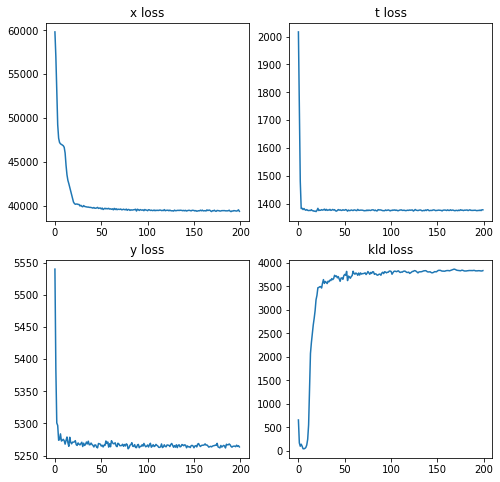

Total loss in the end:  49825.144775390625
Estimated causal effect: [0.03048721 0.90786386] true value: [0, 0.5]


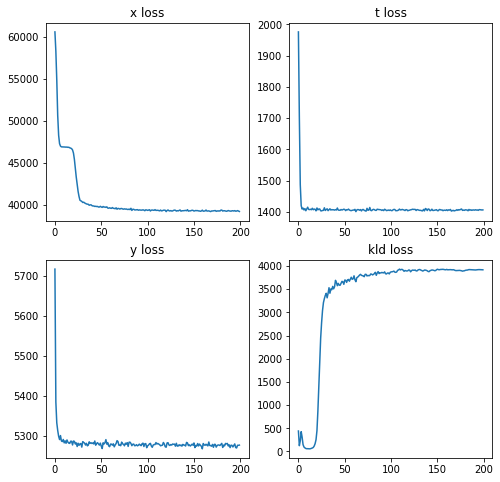

Total loss in the end:  49848.396484375
Estimated causal effect: [-0.00703311  0.91337484] true value: [0, 0.5]


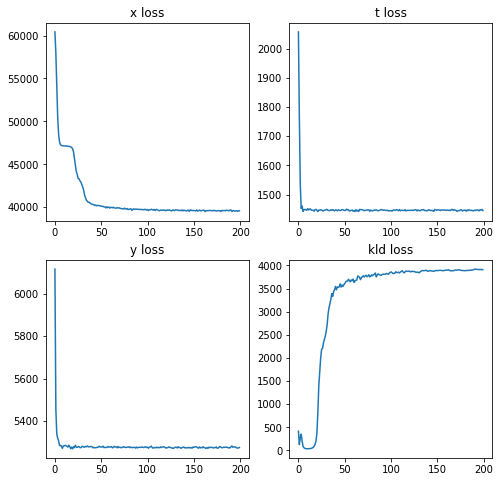

Total loss in the end:  50215.914794921875
Estimated causal effect: [0.02523436 0.87484211] true value: [0, 0.5]


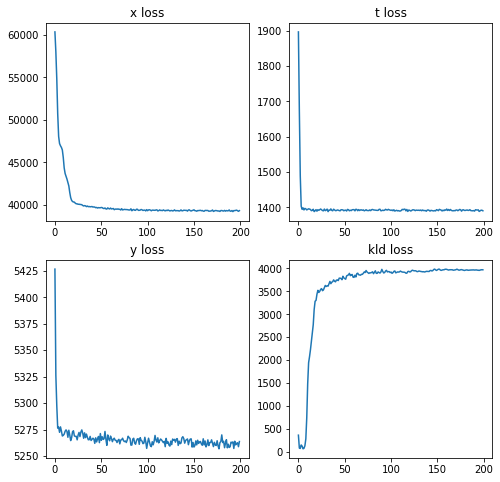

Total loss in the end:  49941.67626953125
Estimated causal effect: [0.02055388 0.84704   ] true value: [0, 0.5]


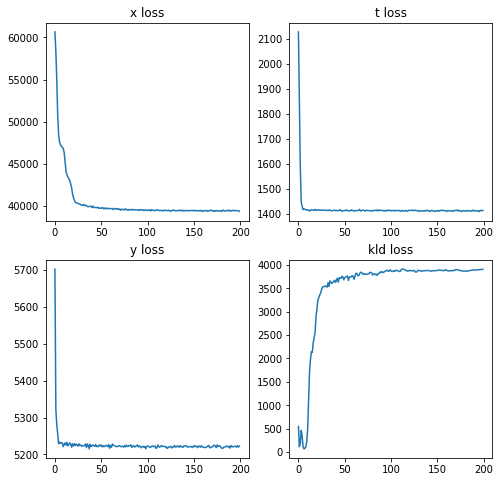

Total loss in the end:  49936.516357421875
Estimated causal effect: [0.00642581 0.92479843] true value: [0, 0.5]


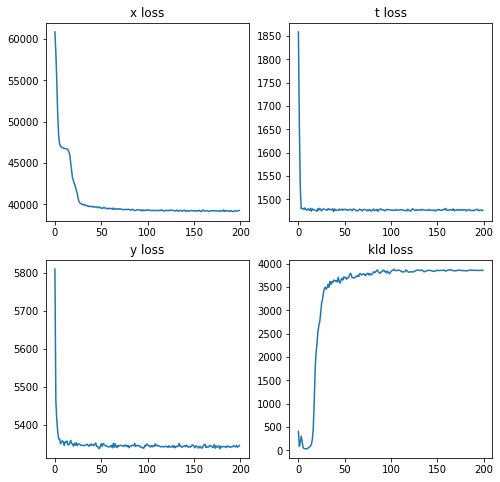

Total loss in the end:  49927.342529296875
Estimated causal effect: [0.03566181 0.82797968] true value: [0, 0.5]


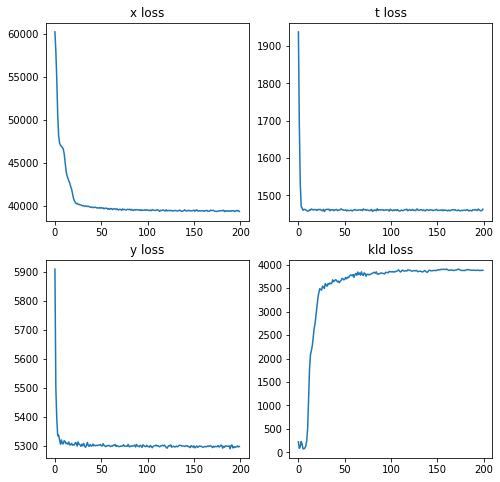

Total loss in the end:  50032.961181640625
Estimated causal effect: [0.00729024 0.89664739] true value: [0, 0.5]


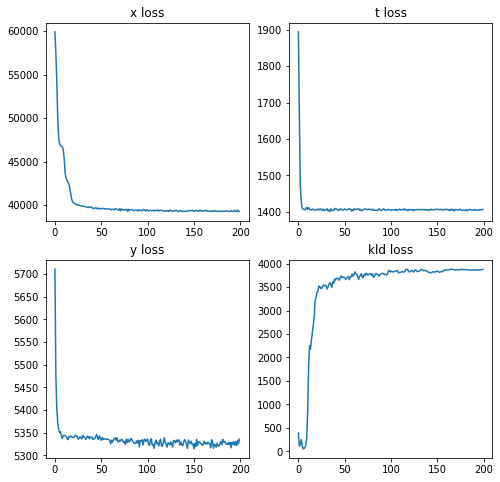

Total loss in the end:  49886.559326171875
Estimated causal effect: [0.05686758 0.94602203] true value: [0, 0.5]


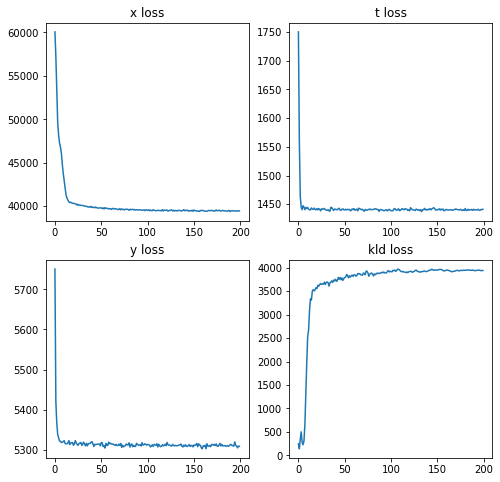

Total loss in the end:  50122.32763671875
Estimated causal effect: [0.03462058 0.91338593] true value: [0, 0.5]


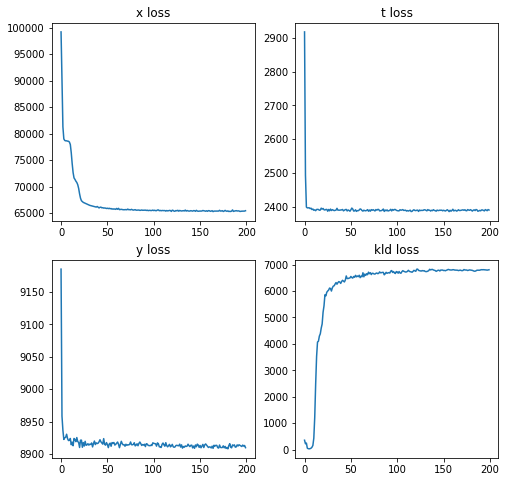

Total loss in the end:  83548.1767578125
Estimated causal effect: [0.00828878 0.87985951] true value: [0, 0.5]


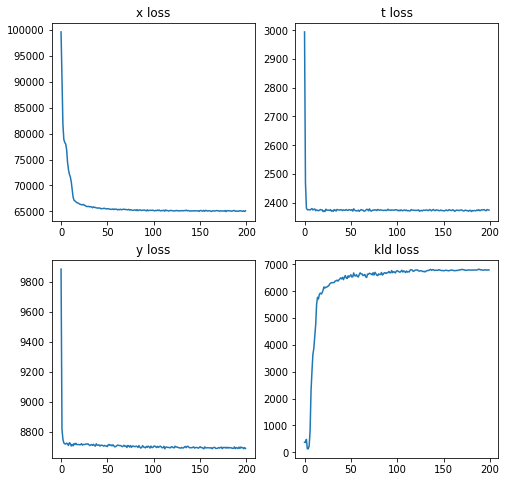

Total loss in the end:  82977.16064453125
Estimated causal effect: [0.00170657 0.91785538] true value: [0, 0.5]


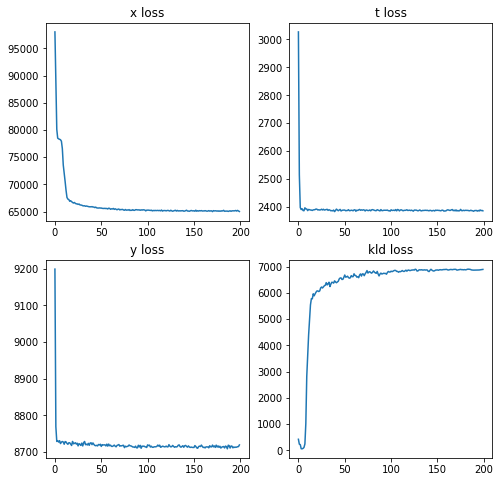

Total loss in the end:  83007.228515625
Estimated causal effect: [0.06518387 0.86668283] true value: [0, 0.5]


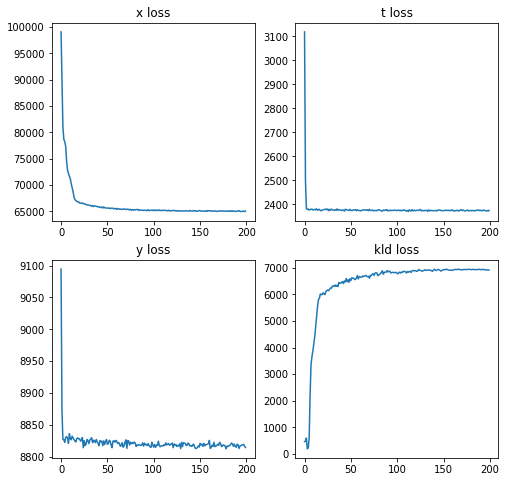

Total loss in the end:  83179.34716796875
Estimated causal effect: [-0.00494228  0.82329917] true value: [0, 0.5]


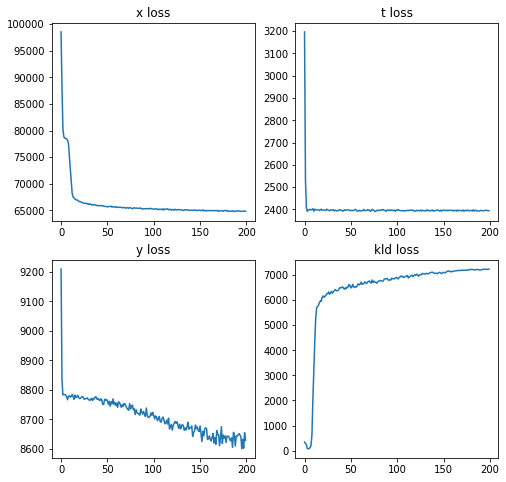

Total loss in the end:  83081.12475585938
Estimated causal effect: [0.07754168 0.94077688] true value: [0, 0.5]


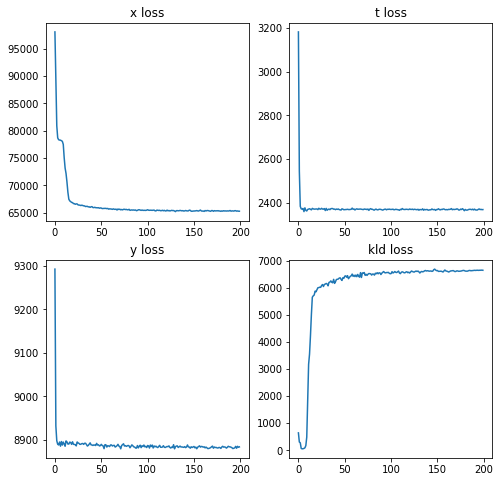

Total loss in the end:  83183.44995117188
Estimated causal effect: [-0.04915191  0.86270553] true value: [0, 0.5]


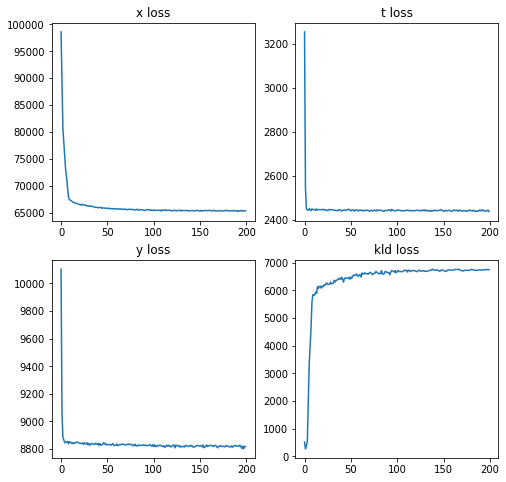

Total loss in the end:  83350.818359375
Estimated causal effect: [0.01733776 0.93419182] true value: [0, 0.5]


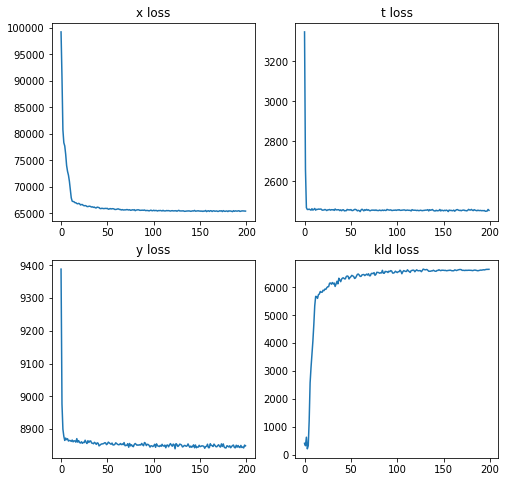

Total loss in the end:  83379.03198242188
Estimated causal effect: [0.04012461 0.8789497 ] true value: [0, 0.5]


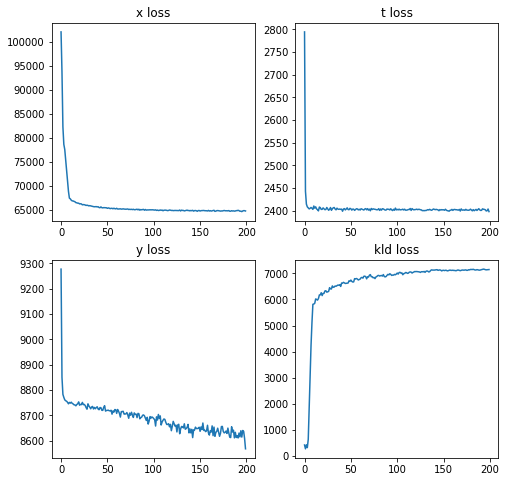

Total loss in the end:  82948.22875976562
Estimated causal effect: [0.02395272 0.83948201] true value: [0, 0.5]


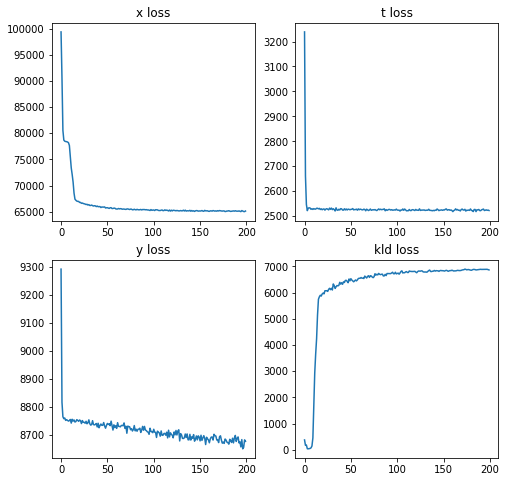

Total loss in the end:  83197.87915039062
Estimated causal effect: [0.02185094 0.83557516] true value: [0, 0.5]


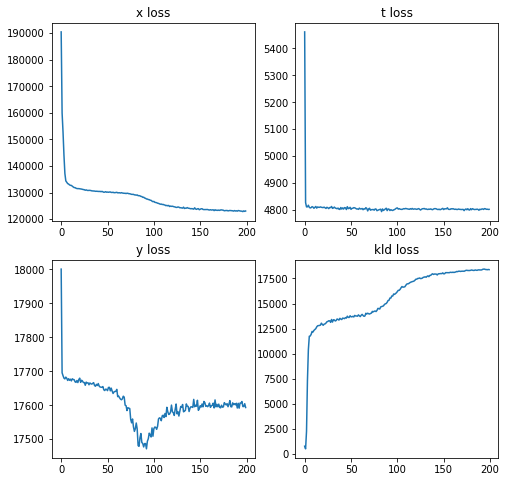

Total loss in the end:  163840.99926757812
Estimated causal effect: [0.04722745 0.83473688] true value: [0, 0.5]


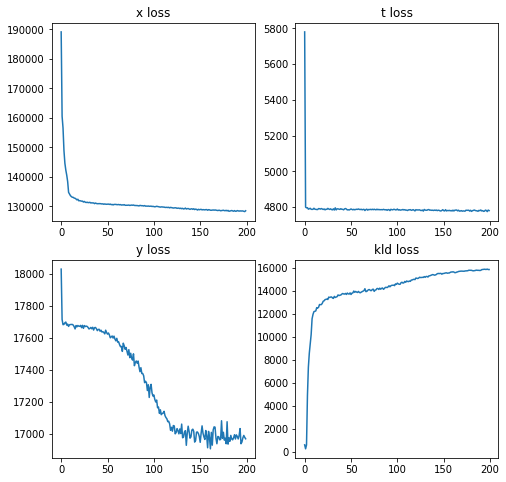

Total loss in the end:  166114.88696289062
Estimated causal effect: [-0.00902568  0.88477689] true value: [0, 0.5]


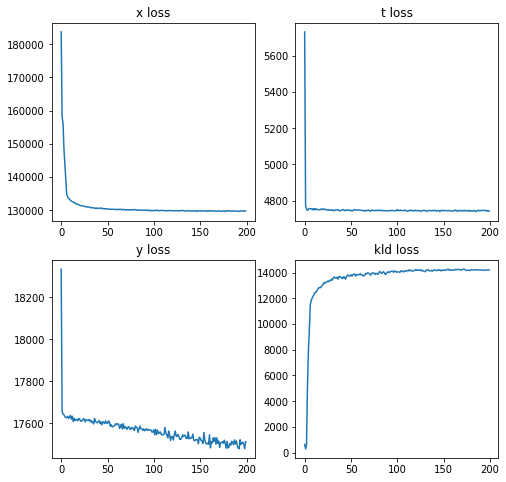

Total loss in the end:  166266.021484375
Estimated causal effect: [0.00869201 0.8129285 ] true value: [0, 0.5]


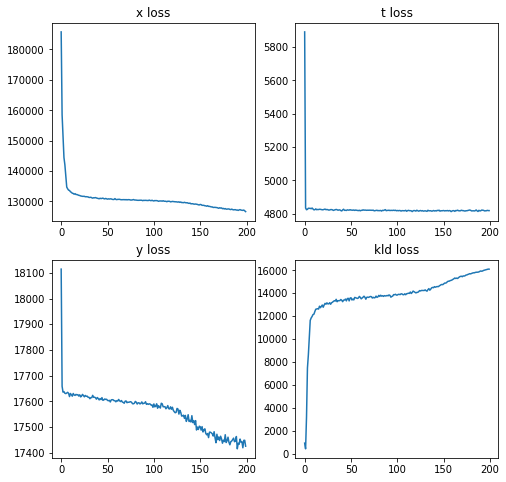

Total loss in the end:  164986.44775390625
Estimated causal effect: [0.02786185 0.89928794] true value: [0, 0.5]


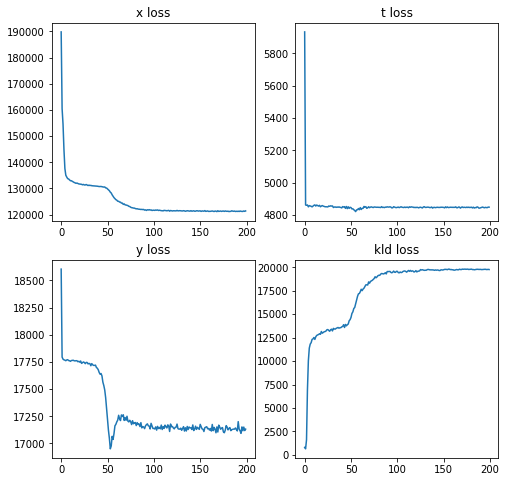

Total loss in the end:  163177.98583984375
Estimated causal effect: [0.02729369 0.81614727] true value: [0, 0.5]


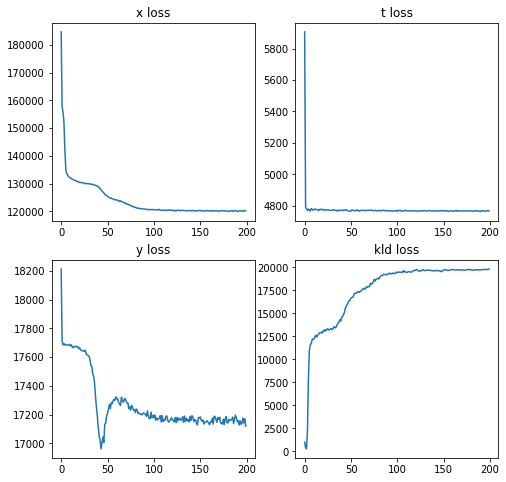

Total loss in the end:  161877.36157226562
Estimated causal effect: [0.05202869 0.93546164] true value: [0, 0.5]


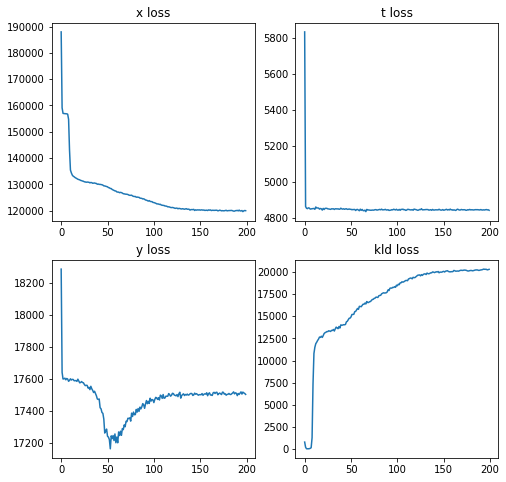

Total loss in the end:  162656.39086914062
Estimated causal effect: [0.04262747 0.88072014] true value: [0, 0.5]


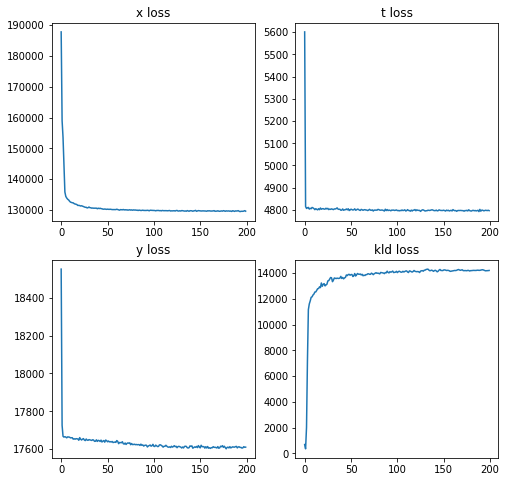

Total loss in the end:  166246.89770507812
Estimated causal effect: [0.0151936  0.87751985] true value: [0, 0.5]


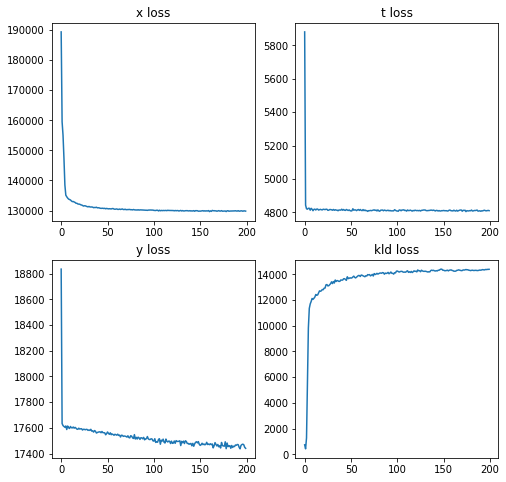

Total loss in the end:  166452.29809570312
Estimated causal effect: [-0.00519369  0.83829826] true value: [0, 0.5]


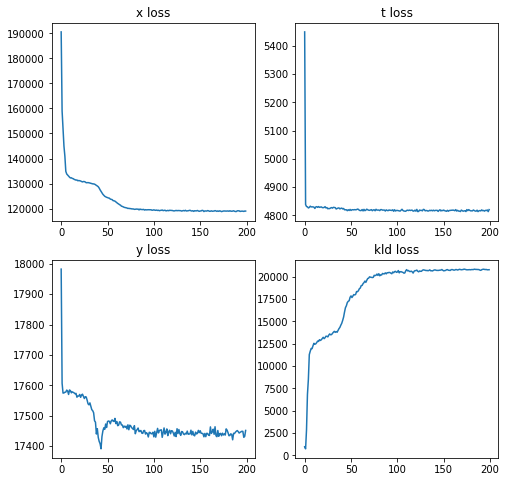

Total loss in the end:  162086.09741210938
Estimated causal effect: [0.03496536 0.86829156] true value: [0, 0.5]


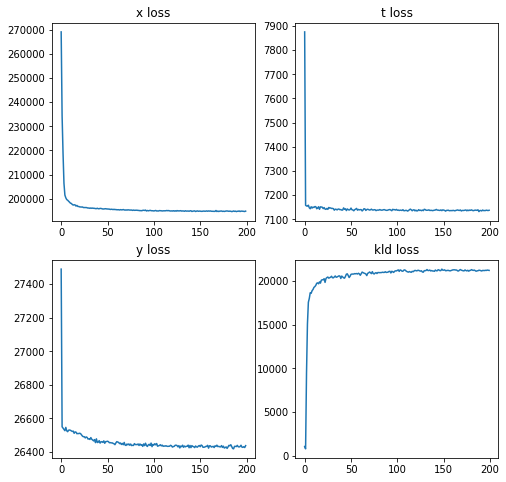

Total loss in the end:  249605.9287109375
Estimated causal effect: [0.01144644 0.87340224] true value: [0, 0.5]


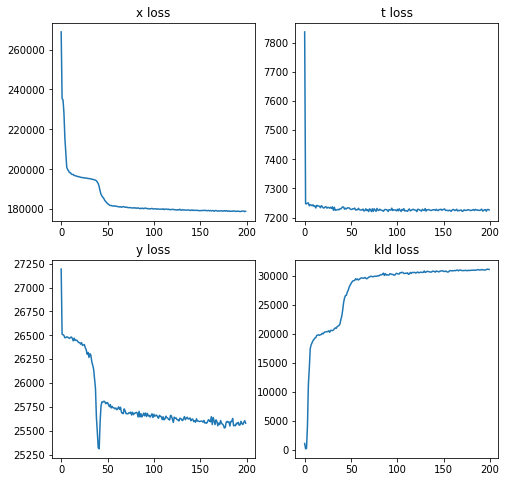

Total loss in the end:  242794.30712890625
Estimated causal effect: [0.01436644 0.93876731] true value: [0, 0.5]


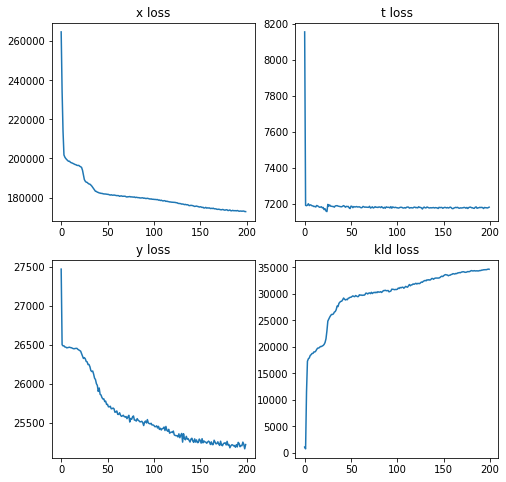

Total loss in the end:  239833.29833984375
Estimated causal effect: [0.02939957 0.8958019 ] true value: [0, 0.5]


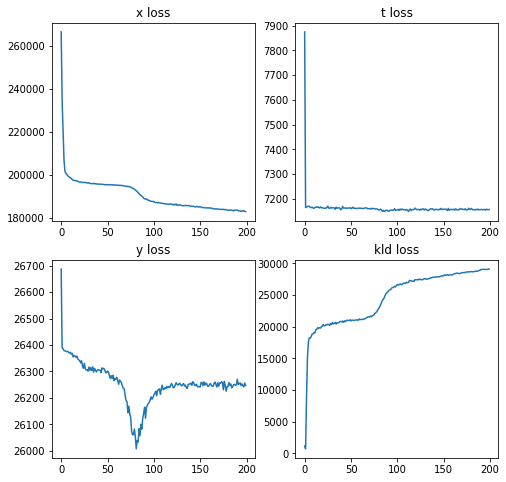

Total loss in the end:  245276.70190429688
Estimated causal effect: [0.01500313 0.87191945] true value: [0, 0.5]


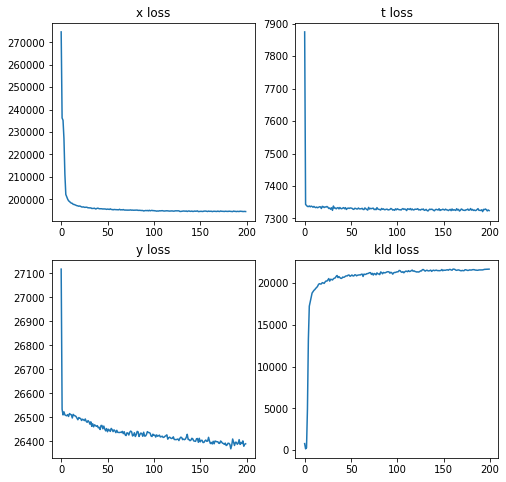

Total loss in the end:  249925.23461914062
Estimated causal effect: [0.02135586 0.82302219] true value: [0, 0.5]


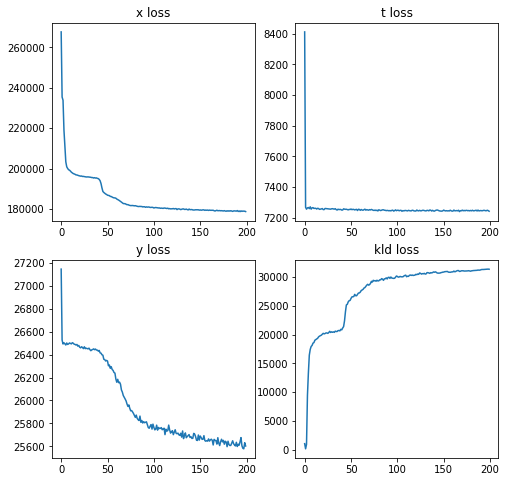

Total loss in the end:  242902.7783203125
Estimated causal effect: [0.01383457 0.90429235] true value: [0, 0.5]


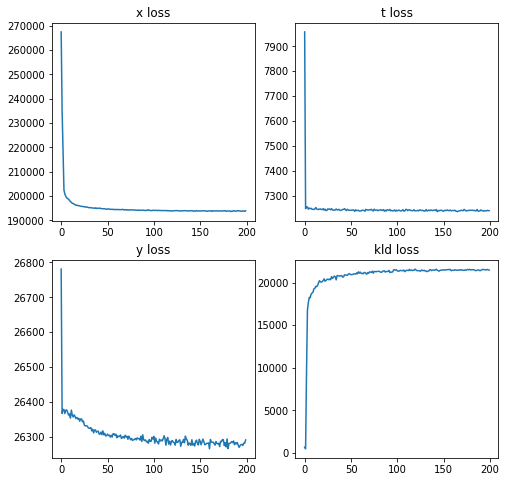

Total loss in the end:  248936.33251953125
Estimated causal effect: [0.04653975 0.87771976] true value: [0, 0.5]


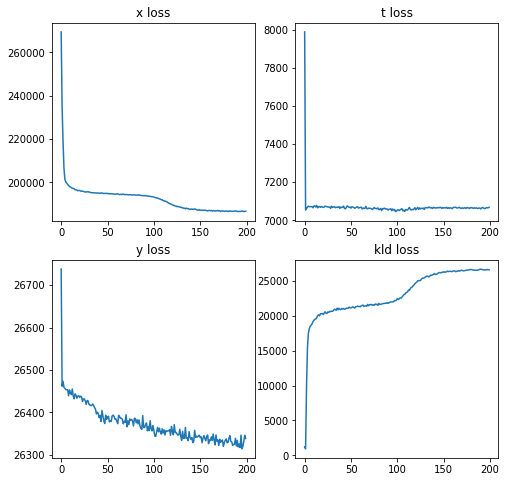

Total loss in the end:  246728.142578125
Estimated causal effect: [0.04271015 0.88699251] true value: [0, 0.5]


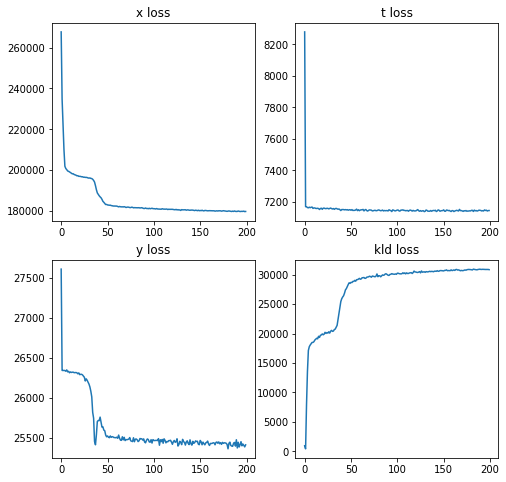

Total loss in the end:  243155.39086914062
Estimated causal effect: [0.02482928 0.90620995] true value: [0, 0.5]


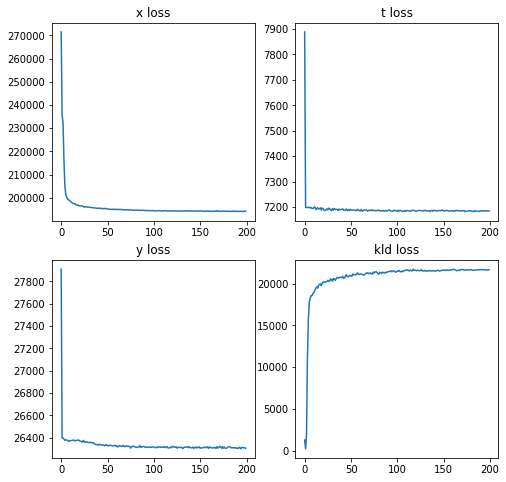

Total loss in the end:  249381.373046875
Estimated causal effect: [0.02520827 0.88013685] true value: [0, 0.5]


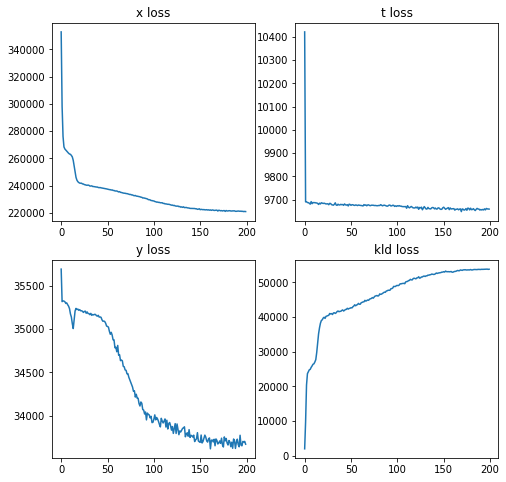

Total loss in the end:  318186.1975097656
Estimated causal effect: [0.0053206 0.9407922] true value: [0, 0.5]


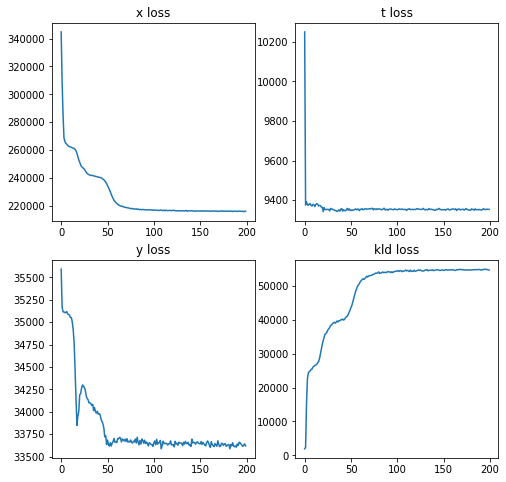

Total loss in the end:  313860.1081542969
Estimated causal effect: [0.02913947 0.86365515] true value: [0, 0.5]


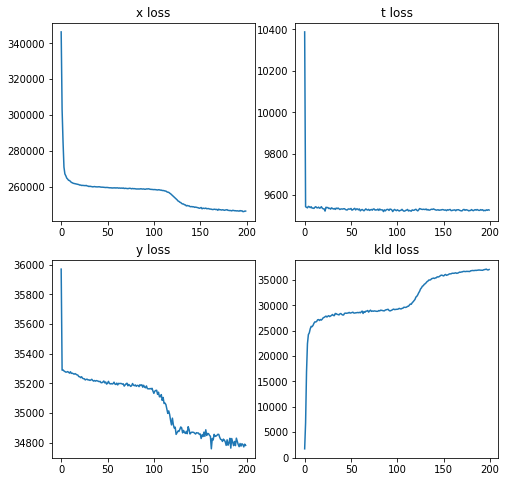

Total loss in the end:  327948.71826171875
Estimated causal effect: [0.00291983 0.87165248] true value: [0, 0.5]


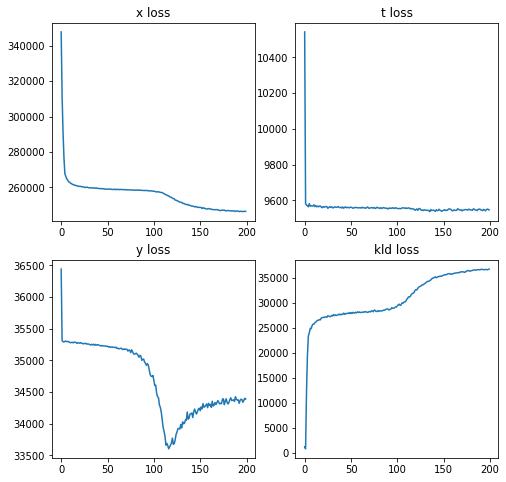

Total loss in the end:  327206.7526855469
Estimated causal effect: [0.0190477  0.89296341] true value: [0, 0.5]


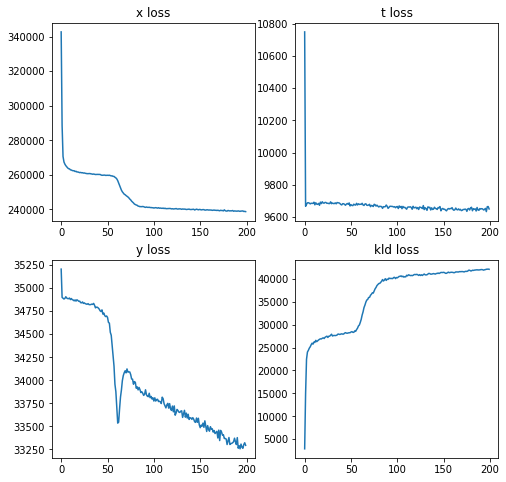

Total loss in the end:  323808.52001953125
Estimated causal effect: [0.02590835 0.82801974] true value: [0, 0.5]


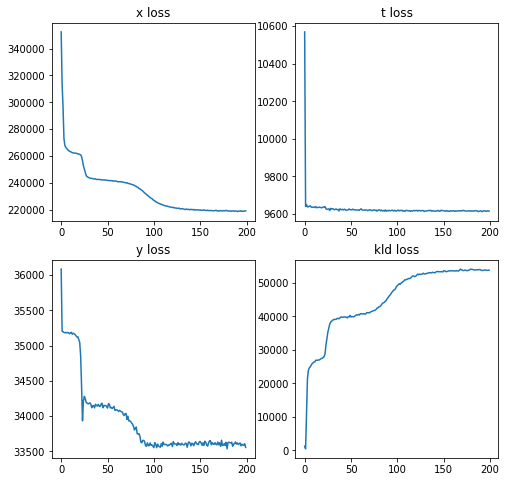

Total loss in the end:  315927.86962890625
Estimated causal effect: [0.01182107 0.91610062] true value: [0, 0.5]


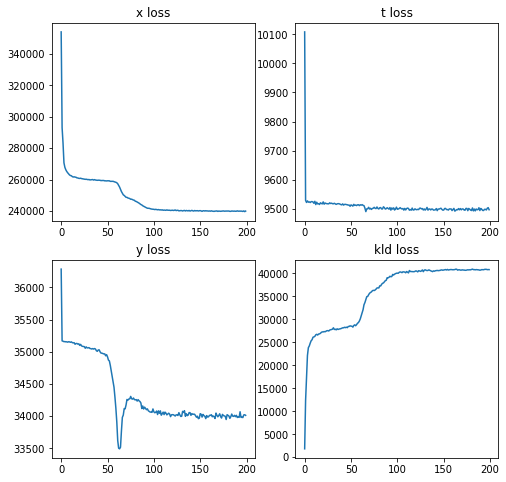

Total loss in the end:  324254.7822265625
Estimated causal effect: [0.01540475 0.87571961] true value: [0, 0.5]


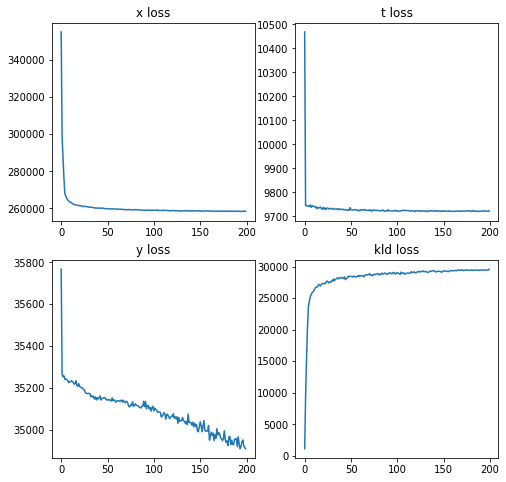

Total loss in the end:  332561.0759277344
Estimated causal effect: [0.03297893 0.83243096] true value: [0, 0.5]


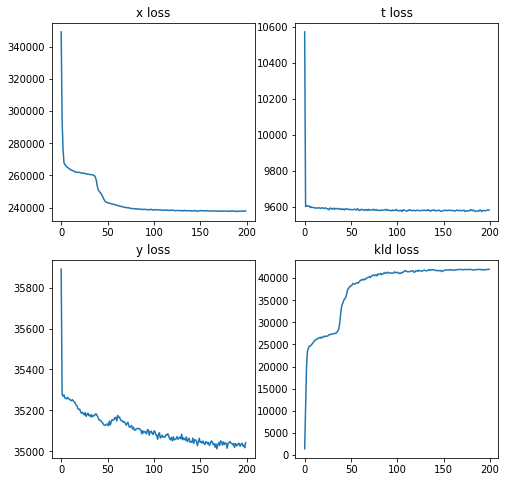

Total loss in the end:  324626.64599609375
Estimated causal effect: [0.04117458 0.8552261 ] true value: [0, 0.5]


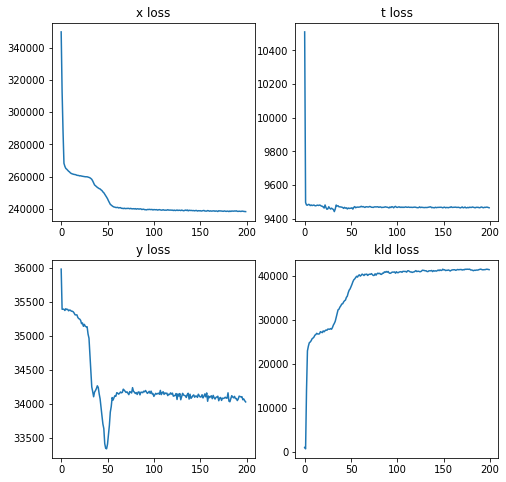

Total loss in the end:  323234.3701171875
Estimated causal effect: [0.03802304 0.90826315] true value: [0, 0.5]


In [326]:
# Run the model
models, losses = run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder_model, 
                                               BATCH_SIZE, track_function, true_value, 
                                               device, train_arguments, labels, data_labels)

# Plotting results

In [28]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]})

## Describe data generating process

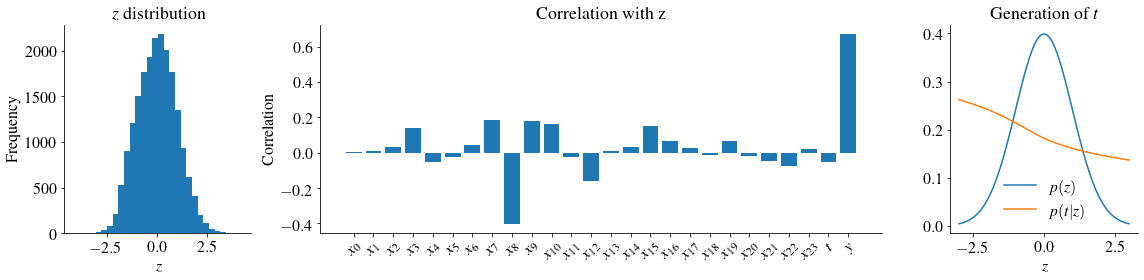

In [31]:
sub_folder = "ATE1samplesize1000to20000"
dfs, datasets = load_dfs(main_folder, sub_folder, param_times)

fig, ax = plt.subplots(1,3, figsize=(16,4),gridspec_kw={"width_ratios":[1,3,1]})

ax[0].hist(dfs['20000'][0].z, bins=30)
ax[0].set_title("$z$ distribution", fontsize=18)
ax[0].set_xlabel('$z$', fontsize=16)
ax[0].set_ylabel("Frequency", fontsize=16)
ax[0].tick_params(which='major', axis='both', labelsize=16)

correlations = dfs['20000'][0].corr().iloc[0,1:]
xlabels = [r"$x_{}$".format("{" + str(i) + "}")  for i in range(24)] + ['$t$','$y$']
ax[1].set_title("Correlation with z", fontsize=18)
ax[1].bar(xlabels, correlations)
ax[1].tick_params(which='major', axis='x', labelrotation=45, labelsize=16)
ax[1].tick_params(which='major', axis='y', labelsize=16)
ax[1].set_ylabel("Correlation", fontsize=16)

zspace = np.linspace(-3,3,100)
tpred = torch.sigmoid(model_zt(torch.Tensor([zspace]).T)).detach().numpy().squeeze()
ax[2].set_title("Generation of $t$", fontsize=18)
ax[2].plot(zspace, scipy.stats.norm.pdf(zspace))
ax[2].plot(zspace, tpred)
ax[2].legend(["$p(z)$", r"$p(t|z)$"], frameon=False, fontsize=16)
ax[2].tick_params(which='major', axis='both', labelsize=16)
ax[2].set_xlabel('$z$', fontsize=16)

for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

## Plots in the main text

### Load loss scaling results and get p(y|do(t))

In [63]:
z_dim=10
scaling_labels = [str(s) for s in [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]]
train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]

sub_folder_model = "ATE1zdim10samplesize20000modelsscalings"

models_zdim10, losses_zdim10 = load_models_losses(main_folder, sub_folder_model, train_arguments, scaling_labels, device)

In [34]:
param_times = 30
pydot1_zdim10 = np.zeros((param_times, len(labels)))
pydot0_zdim10 = np.zeros((param_times, len(labels)))

for i,label in enumerate(map(str,labels)):
    print(label)
    for j in range(param_times):
        py_dot = estimate_model_py_dot(models_zdim10[label][j],n=10000)
        pydot1_zdim10[j,i] = py_dot[1]
        pydot0_zdim10[j,i] = py_dot[0]

1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1


### Get direct adjustment and no adjustment values

In [103]:
#NOTE: These are for the data set we trained the loss scaling models with
sub_folder = "ATE1samplesize20000times10"
dfs_ate1, datasets_ate1 = load_dfs(main_folder, sub_folder, param_times)
df = dfs_ate1['df20000'][0]
pc_pydot1 = df[df['t']==1]['y'].mean()
pc_pydot0 = df[df['t']==0]['y'].mean()

0.8369796

In [101]:
true_pydot1 = 1
true_pydot0 = 0


from sklearn.ensemble import RandomForestRegressor
cols = df.columns.str.startswith("x")
rf1 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==1], df["y"][df.t==1])
rf0 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==0], df["y"][df.t==0])
direct_pydot1 = rf1.predict(df.iloc[:,cols]).mean()
direct_pydot0 = rf0.predict(df.iloc[:,cols]).mean()

### Load convergence results and get p(y|do(t))

In [70]:
train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]
sub_folder_model = "ATE1zdim10samplesize1000to20000"
samplesize_labels = [str(s) for s in [1000,2000,3000,5000,10000,15000,20000]]

models, losses = load_models_losses(main_folder, sub_folder_model, train_arguments, samplesize_labels, device)

In [73]:
param_times = 10
pydot1_conv = np.zeros((param_times, len(labels)))
pydot0_conv = np.zeros((param_times, len(labels)))

for i,label in enumerate(map(str,labels)):
    print(label)
    for j in range(param_times):
        py_dot = estimate_model_py_dot(models[label][j],n=10000)
        pydot1_conv[j,i] = py_dot[1]
        pydot0_conv[j,i] = py_dot[0]

1000
2000
3000
5000
10000
15000
20000


In [106]:
from sklearn.ensemble import RandomForestRegressor
#This is the average of a large data set, i.e., the asymptotic value
df = dfs['20000'][0]
for i in range(1,5):
    df = df.append(dfs['20000'][i])
cols = df.columns.str.startswith("x")
rf1 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==1], df["y"][df.t==1])
rf0 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==0], df["y"][df.t==0])
direct_pydot1_asymp = rf1.predict(df.iloc[:,cols]).mean()
direct_pydot0_asymp = rf0.predict(df.iloc[:,cols]).mean()

### Plots

In [89]:
scaling_labels = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

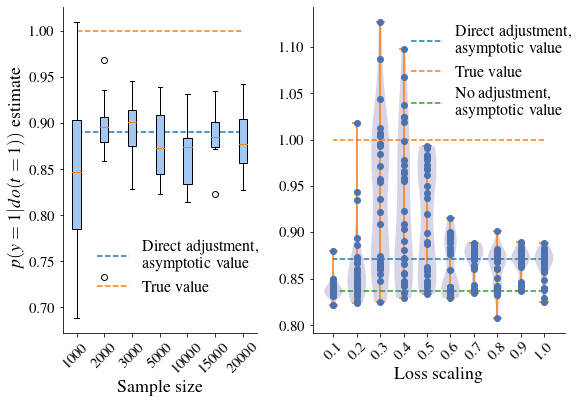

In [107]:
import seaborn as sns
from matplotlib.patches import Patch

fig, ax = plt.subplots(1,2,figsize=(9,6), gridspec_kw = {'wspace':0.25, 'hspace':0, 'width_ratios': [1, 1.3]})
samplesize_places = list(range(len(samplesize_labels)))
scaling_places = list(range(len(scaling_labels)))
width = 0.3

palette = sns.color_palette("pastel")
ax[0].plot([samplesize_places[0],samplesize_places[-1]],[direct_pydot1_asymp,direct_pydot1_asymp],'--')
ax[0].plot([samplesize_places[0],samplesize_places[-1]],[true_pydot1,true_pydot1],'--')
ax[0].legend(["Direct adjustment,\nasymptotic value","True value"], frameon=False, fontsize=16,
            loc="right", bbox_to_anchor=(1.09,0.2))
ax[0].set_ylabel("$p(y=1|do(t=1))$ estimate", fontsize=18)
ax[0].set_xlabel("Sample size", fontsize=18)

for i in range(len(samplesize_places)):
    bplot = ax[0].boxplot(pydot1_conv[:,i], positions=[samplesize_places[i]], widths=[width], patch_artist=True)
    color = palette[0]
    for patch in bplot['boxes']:
        patch.set_facecolor(color)
ax[0].set_xticks(samplesize_places)
ax[0].set_xticklabels(datasize)
custom_line = Patch(facecolor=palette[0], edgecolor='black')

ax[1].plot([scaling_labels[0],scaling_labels[-1]],[direct_pydot1, direct_pydot1], '--')
ax[1].plot([scaling_labels[0],scaling_labels[-1]],[true_pydot1, true_pydot1], '--')
ax[1].plot([scaling_labels[0],scaling_labels[-1]],[pc_pydot1, pc_pydot1], '--')
for i,label in enumerate(scaling_labels):
    ax[1].plot([label]*param_times*3, pydot1_zdim10[:,i], 'o', color=palette_3[0])
    parts1 = ax[1].violinplot(pydot1_zdim10[:,i], [label],widths=0.08)
    #for pc in parts0['bodies']:
    #    pc.set_facecolor(palette[4])
    for pc in parts1['bodies']:
        pc.set_facecolor(palette_3[4])
    edgecoloridx = 1
    parts1['cbars']._edgecolors = np.array([list(palette_2[edgecoloridx]) + [1]])
    parts1['cmaxes']._edgecolors = np.array([list(palette_2[edgecoloridx]) + [1]])
    parts1['cmins']._edgecolors = np.array([list(palette_2[edgecoloridx]) + [1]])
ax[1].set_xlabel("Loss scaling", fontsize=18)
ax[1].set_xticks(scaling_labels)

ax[1].legend(["Direct adjustment,\nasymptotic value",
              "True value","No adjustment,\nasymptotic value"], frameon=False, fontsize=16, loc="right", 
             bbox_to_anchor=(1.09,0.8))

for i in range(2):
    ax[i].tick_params(axis='x', which='major', labelsize=15, rotation=45)
    ax[i].tick_params(axis='y', which='major', labelsize=15)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    
plt.savefig("Figures/publication/ihdp_mainresults.png", bbox_inches = 'tight', pad_inches = 0.0, dpi=200)
plt.show()

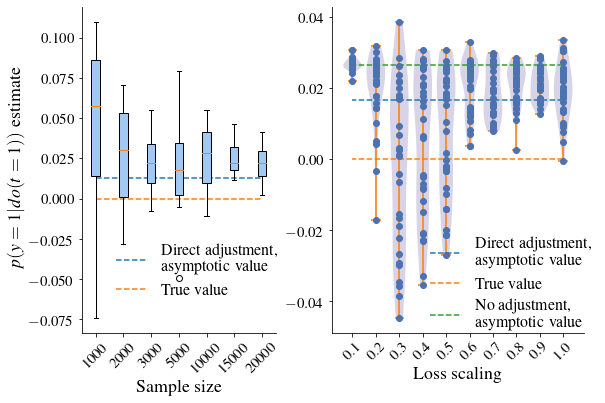

In [111]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(1,2,figsize=(9,6), gridspec_kw = {'wspace':0.25, 'hspace':0, 'width_ratios': [1, 1.3]})
samplesize_places = list(range(len(samplesize_labels)))
scaling_places = list(range(len(scaling_labels)))
width = 0.3

palette = sns.color_palette("pastel")
ax[0].plot([samplesize_places[0],samplesize_places[-1]],[direct_pydot0_asymp,direct_pydot0_asymp],'--')
ax[0].plot([samplesize_places[0],samplesize_places[-1]],[true_pydot0,true_pydot0],'--')
ax[0].legend(["Direct adjustment,\nasymptotic value","True value"], frameon=False, fontsize=16,
            loc="right", bbox_to_anchor=(1.09,0.19))
ax[0].set_ylabel("$p(y=1|do(t=1))$ estimate", fontsize=18)
ax[0].set_xlabel("Sample size", fontsize=18)

for i in range(len(samplesize_places)):
    bplot = ax[0].boxplot(pydot0_conv[:,i], positions=[samplesize_places[i]], widths=[width], patch_artist=True)
    color = palette[0]
    for patch in bplot['boxes']:
        patch.set_facecolor(color)
ax[0].set_xticks(samplesize_places)
ax[0].set_xticklabels(datasize)
custom_line = Patch(facecolor=palette[0], edgecolor='black')

ax[1].plot([scaling_labels[0],scaling_labels[-1]],[direct_pydot0, direct_pydot0], '--')
ax[1].plot([scaling_labels[0],scaling_labels[-1]],[true_pydot0, true_pydot0], '--')
ax[1].plot([scaling_labels[0],scaling_labels[-1]],[pc_pydot0, pc_pydot0], '--')
for i,label in enumerate(scaling_labels):
    ax[1].plot([label]*param_times*3, pydot0_zdim10[:,i], 'o', color=palette_3[0])
    parts1 = ax[1].violinplot(pydot0_zdim10[:,i], [label],widths=0.08)
    #for pc in parts0['bodies']:
    #    pc.set_facecolor(palette[4])
    for pc in parts1['bodies']:
        pc.set_facecolor(palette_3[4])
    edgecoloridx = 1
    parts1['cbars']._edgecolors = np.array([list(palette_2[edgecoloridx]) + [1]])
    parts1['cmaxes']._edgecolors = np.array([list(palette_2[edgecoloridx]) + [1]])
    parts1['cmins']._edgecolors = np.array([list(palette_2[edgecoloridx]) + [1]])
ax[1].set_xlabel("Loss scaling", fontsize=18)
ax[1].set_xticks(scaling_labels)

ax[1].legend(["Direct adjustment,\nasymptotic value",
              "True value","No adjustment,\nasymptotic value"], frameon=False, fontsize=16, loc="right", 
             bbox_to_anchor=(1.09,0.15))

for i in range(2):
    ax[i].tick_params(axis='x', which='major', labelsize=15, rotation=45)
    ax[i].tick_params(axis='y', which='major', labelsize=15)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    
plt.show()